In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve
from tqdm import tqdm
import pandas as pd
from scipy.stats import entropy
import copy
import math
from environments import SBEOS_Environment
#from environments_f import SBEOS_Environment
time_dependence = 3
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transition tuple for experience replay
Transition = namedtuple('Transition', 
                        ('state', 'action', 'next_state', 'reward', 'done', 'priority'))

class PrioritizedReplayBuffer:
    """Prioritized Experience Replay Buffer for important transitions"""
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=1e-6):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.alpha = alpha  # How much prioritization to use (0 = no prioritization, 1 = full prioritization)
        self.beta = beta  # Correction factor for importance sampling
        self.beta_increment = beta_increment  # Beta increases over time for stable learning
        self.epsilon = epsilon  # Small constant to avoid zero probabilities
        self.max_priority = 1.0  # Initial priority for new transitions
        
    def push(self, *args):
        """Save a transition to the replay buffer with max priority"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        # Use max priority for new transitions (ensures they're sampled at least once)
        priority = self.max_priority ** self.alpha
        self.priorities[self.position] = priority
        
        # Store transition
        self.memory[self.position] = Transition(*args, priority=priority)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        """Sample a batch of transitions based on their priorities"""
        if len(self.memory) < self.capacity:
            probs = self.priorities[:len(self.memory)] / sum(self.priorities[:len(self.memory)])
        else:
            probs = self.priorities / sum(self.priorities)
            
        # Sample indices based on priorities
        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        
        # Calculate importance sampling weights
        total = len(self.memory)
        weights = (total * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # Normalize weights
        
        # Increment beta for next sampling
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # Get transitions for the sampled indices
        transitions = [self.memory[idx] for idx in indices]
        
        # Return batch with additional metadata
        batch = Transition(*zip(*transitions))
        return batch, weights, indices
    
    def update_priorities(self, indices, priorities):
        """Update priorities based on TD errors"""
        for idx, priority in zip(indices, priorities):
            # Add small epsilon to avoid zero priority
            priority = (priority + self.epsilon) ** self.alpha
            self.priorities[idx] = priority
            self.max_priority = max(self.max_priority, priority)
    
    def __len__(self):
        return len(self.memory)

class FeatureExtractor(nn.Module):
    """Feature extraction module for detecting patterns in the environment state"""
    def __init__(self, state_size, feature_dim=64):
        super(FeatureExtractor, self).__init__()
        
        # Convolutional layers for pattern detection in the observation window
        self.window_size = state_size - 6  # Raw window part of state
        
        # For processing the raw window
        self.conv_layers = nn.Sequential(
            nn.Linear(self.window_size, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
        )
        
        # For processing the statistical features
        self.feature_layers = nn.Sequential(
            nn.Linear(6, 16),  # 6 statistical features
            nn.LeakyReLU()
        )
        
        # Combined processing
        self.combined_layers = nn.Sequential(
            nn.Linear(32 + 16, feature_dim),
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        # Split input into raw window and statistical features
        window = x[:, :self.window_size]
        features = x[:, self.window_size:]
        
        # Process through respective paths
        window_features = self.conv_layers(window)
        stat_features = self.feature_layers(features)
        
        # Combine features
        combined = torch.cat([window_features, stat_features], dim=1)
        return self.combined_layers(combined)

class EnhancedDQN(nn.Module):
    """Enhanced DQN with feature extraction, dueling architecture, and noisy layers"""
    def __init__(self, state_size, action_size, hidden_dim=128, noisy=True):
        super(EnhancedDQN, self).__init__()
        
        # Feature extraction
        self.feature_extractor = FeatureExtractor(state_size, feature_dim=64)
        
        # Common hidden layers with residual connections
        self.hidden_layers = nn.Sequential(
            nn.Linear(64, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.1)
        )
        
        # Short residual connection
        self.residual_proj = nn.Linear(64, hidden_dim)
        
        # Value stream (estimates state value)
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Advantage stream (estimates action advantages)
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim // 2, action_size)
        )
        
        # Noisy layer flag for exploration
        self.noisy = noisy
        if noisy:
            # Replace last layers with noisy layers for intrinsic exploration
            self.value_noisy = NoisyLinear(hidden_dim // 2, 1)
            self.advantage_noisy = NoisyLinear(hidden_dim // 2, action_size)
        
    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)
        
        # Process through hidden layers with residual connection
        hidden = self.hidden_layers(features)
        residual = self.residual_proj(features)
        combined = hidden + residual
        
        # Compute value and advantage
        if self.noisy:
            # Use noisy layers for value and advantage
            value = self.value_stream[:-1](combined)  # All but last layer
            value = self.value_noisy(value)
            
            advantage = self.advantage_stream[:-1](combined)
            advantage = self.advantage_noisy(advantage)
        else:
            # Use standard layers
            value = self.value_stream(combined)
            advantage = self.advantage_stream(combined)
            
        # Combine value and advantages using dueling architecture formula
        return value + advantage - advantage.mean(dim=1, keepdim=True)
    
    def reset_noise(self):
        """Reset noise for exploration"""
        if self.noisy:
            self.value_noisy.reset_noise()
            self.advantage_noisy.reset_noise()

class NoisyLinear(nn.Module):
    """Noisy linear layer for exploration"""
    def __init__(self, in_features, out_features, std_init=0.1):
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        
        # Mean weights and biases
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
        
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))
        self.register_buffer('bias_epsilon', torch.empty(out_features))
        
        self.reset_parameters()
        self.reset_noise()
        
    def reset_parameters(self):
        """Initialize parameters"""
        mu_range = 1.0 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))
        
    def reset_noise(self):
        """Reset the noise for exploration"""
        epsilon_in = self._scale_noise(self.in_features)
        epsilon_out = self._scale_noise(self.out_features)
        
        # Outer product
        self.weight_epsilon.copy_(epsilon_out.outer(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)
        
    def _scale_noise(self, size):
        """Scale noise for factorized Gaussian noise"""
        noise = torch.randn(size, device=self.weight_mu.device)
        return torch.sign(noise) * torch.sqrt(torch.abs(noise))
        
    def forward(self, x):
        """Forward pass with noise"""
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
            
        return F.linear(x, weight, bias)

class LSTMNetwork(nn.Module):
    """LSTM network for temporal pattern recognition"""
    def __init__(self, state_size, action_size, hidden_dim=128):
        super(LSTMNetwork, self).__init__()
        
        # LSTM for sequence processing
        self.lstm = nn.LSTM(state_size, hidden_dim, batch_first=True)
        
        # Feature extraction after LSTM
        self.feature_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim // 2, action_size)
        )
        
    def forward(self, x, hidden=None):
        # Reshape for LSTM if needed
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension
            
        # Process through LSTM
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        
        # Extract features
        features = self.feature_layer(lstm_out)
        
        # Calculate value and advantage
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        
        # Combine using dueling architecture
        return value + advantage - advantage.mean(dim=1, keepdim=True), hidden

class EnhancedDQNAgent:
    def __init__(
        self,
        state_size,
        action_size,
        memory_size=100000,
        batch_size=128,
        gamma=0.99,
        tau=0.005,  # Soft update parameter
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,  # Steps for decay
        learning_rate=0.0003,
        target_update_freq=5,  # Update target every n episodes for hard updates
        double_dqn=True,
        prioritized_replay=True,  # Use prioritized experience replay
        n_step_return=3,  # Number of steps for n-step return
        use_recurrent=False,  # Use LSTM network
        use_noisy_nets=True,  # Use noisy networks for exploration
        use_soft_targets=True,  # Use soft target updates
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.double_dqn = double_dqn
        self.learning_rate = learning_rate
        self.n_step_return = n_step_return
        self.use_recurrent = use_recurrent
        self.use_noisy_nets = use_noisy_nets
        self.use_soft_targets = use_soft_targets
        self.steps_done = 0
        
        # For n-step returns
        self.n_step_buffer = deque(maxlen=n_step_return)
        
        # Initialize replay buffer
        if prioritized_replay:
            self.memory = PrioritizedReplayBuffer(memory_size)
            self.prioritized_replay = True
        else:
            self.memory = deque(maxlen=memory_size)
            self.prioritized_replay = False
        
        # Initialize networks
        if use_recurrent:
            self.policy_net = LSTMNetwork(state_size, action_size).to(device)
            self.target_net = LSTMNetwork(state_size, action_size).to(device)
            self.hidden = None  # LSTM hidden state
        else:
            self.policy_net = EnhancedDQN(state_size, action_size, noisy=use_noisy_nets).to(device)
            self.target_net = EnhancedDQN(state_size, action_size, noisy=use_noisy_nets).to(device)
            
        # Initialize target network with policy network weights
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Set target network to evaluation mode
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Learning rate scheduler for adaptive learning
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=10, verbose=True
        )
        
        # Training metrics
        self.rewards_history = []
        self.losses = []
        self.accuracies = []
        self.predictions = []
        self.true_states = []
        
        # Episode tracking for target updates
        self.episode_count = 0
        
    def select_action(self, state, evaluate=False, hidden=None):
        """Select an action using policy"""
        # Epsilon-greedy action selection
        if not self.use_noisy_nets and not evaluate and random.random() < self.epsilon:
            return random.randrange(self.action_size), hidden
        
        # Convert state to tensor
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state_tensor = torch.FloatTensor(state).to(device)
            else:
                state_tensor = torch.FloatTensor([state]).to(device)
                
            # Make sure it has batch dimension
            if state_tensor.dim() == 1:
                state_tensor = state_tensor.unsqueeze(0)
            
            # Get Q-values
            if self.use_recurrent:
                q_values, new_hidden = self.policy_net(state_tensor, hidden)
                return q_values.argmax(1)[0].item(), new_hidden
            else:
                q_values = self.policy_net(state_tensor)
                return q_values.argmax(1).item(), None
    
    def update_epsilon(self):
        """Update epsilon using exponential decay"""
        self.epsilon = self.epsilon_end + (self.epsilon - self.epsilon_end) * \
                       math.exp(-1. * self.steps_done / self.epsilon_decay)
        self.steps_done += 1
    
    def remember(self, state, action, reward, next_state, done):
        """Store transition in replay memory with n-step returns"""
        # Store transition in the n-step buffer
        self.n_step_buffer.append((state, action, reward, next_state, done))
        
        # If the n-step buffer is full, compute n-step return
        if len(self.n_step_buffer) == self.n_step_return:
            state, action, n_reward, next_state, done = self.get_n_step_info()
            
            if self.prioritized_replay:
                # Initially use max priority for new experiences
                self.memory.push(state, action, next_state, n_reward, done)
            else:
                self.memory.append((state, action, next_state, n_reward, done))
    
    def get_n_step_info(self):
        """Get n-step transition info from n-step buffer"""
        # Get first transition from buffer
        state, action, reward, next_state, done = self.n_step_buffer[0]
        
        # Calculate cumulative reward with discount
        for idx in range(1, len(self.n_step_buffer)):
            r, next_s, d = self.n_step_buffer[idx][2:5]
            reward = reward + self.gamma ** idx * r
            
            # If transition is terminal, break
            if d:
                done = True
                next_state = next_s
                break
        
        return state, action, reward, next_state, done
    
    def replay(self):
        """Train the model with experiences from replay buffer"""
        if self.prioritized_replay and len(self.memory) < self.batch_size:
            return 0
        elif not self.prioritized_replay and len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        if self.prioritized_replay:
            transitions, weights, indices = self.memory.sample(self.batch_size)
            weights = torch.FloatTensor(weights).to(device)
            
            # Convert batch to tensors
            state_batch = torch.FloatTensor(np.array(transitions.state)).to(device)
            action_batch = torch.LongTensor(transitions.action).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(transitions.reward).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(np.array(transitions.next_state)).to(device)
            done_batch = torch.FloatTensor(transitions.done).unsqueeze(1).to(device)
        else:
            # Randomly sample from memory
            transitions = random.sample(self.memory, self.batch_size)
            state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*transitions)
            
            # Convert to tensors
            state_batch = torch.FloatTensor(np.array(state_batch)).to(device)
            action_batch = torch.LongTensor(action_batch).unsqueeze(1).to(device)
            reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(device)
            next_state_batch = torch.FloatTensor(np.array(next_state_batch)).to(device)
            done_batch = torch.FloatTensor(done_batch).unsqueeze(1).to(device)
            weights = torch.ones_like(reward_batch)
        
        # Compute current Q values
        if self.use_recurrent:
            current_q_values, _ = self.policy_net(state_batch)
            current_q_values = current_q_values.gather(1, action_batch)
        else:
            current_q_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute next Q values based on algorithm choice
        with torch.no_grad():
            if self.double_dqn:
                # Double DQN: Use policy network to select actions
                if self.use_recurrent:
                    next_q_values_policy, _ = self.policy_net(next_state_batch)
                    next_actions = next_q_values_policy.max(1, keepdim=True)[1]
                    
                    next_q_values_target, _ = self.target_net(next_state_batch)
                    next_q_values = next_q_values_target.gather(1, next_actions)
                else:
                    next_actions = self.policy_net(next_state_batch).max(1, keepdim=True)[1]
                    next_q_values = self.target_net(next_state_batch).gather(1, next_actions)
            else:
                # Standard DQN: Use max Q-value from target network
                if self.use_recurrent:
                    next_q_values, _ = self.target_net(next_state_batch)
                    next_q_values = next_q_values.max(1, keepdim=True)[0]
                else:
                    next_q_values = self.target_net(next_state_batch).max(1, keepdim=True)[0]
            
            # Compute expected Q values
            expected_q_values = reward_batch + self.gamma**self.n_step_return * next_q_values * (1 - done_batch)
        
        # Compute loss (Huber loss for stability)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values, reduction='none')
        
        # Apply importance sampling weights for prioritized replay
        weighted_loss = (loss * weights).mean()
        
        # Compute TD errors for updating priorities
        if self.prioritized_replay:
            with torch.no_grad():
                td_errors = torch.abs(current_q_values - expected_q_values).cpu().numpy()
                self.memory.update_priorities(indices, td_errors)
        
        # Optimize the model
        self.optimizer.zero_grad()
        weighted_loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()
        
        # Reset noise for NoisyNets
        if self.use_noisy_nets and not self.use_recurrent:
            self.policy_net.reset_noise()
        
        return weighted_loss.item()
    
    def update_target_network(self):
        """Update target network weights"""
        # Increment episode counter
        self.episode_count += 1
        
        if self.use_soft_targets:
            # Soft update
            for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                target_param.data.copy_(self.tau * policy_param.data + (1.0 - self.tau) * target_param.data)
        elif self.episode_count % self.target_update_freq == 0:
            # Hard update
            self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def save_model(self, filepath):
        """Save model weights"""
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'steps_done': self.steps_done
        }, filepath)
        
    def load_model(self, filepath):
        """Load model weights"""
        checkpoint = torch.load(filepath)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.epsilon = checkpoint['epsilon']
        self.steps_done = checkpoint['steps_done']
        self.target_net.eval()


def evaluate_episode(env, agent):
    """Evaluate the agent on a single episode without exploration"""
    state = env.reset()
    done = False
    total_reward = 0
    
    # Initialize LSTM hidden state for recurrent models
    if agent.use_recurrent:
        hidden = None
        state_sequence = deque(maxlen=4)
        state_sequence.append(state)
        
        # Initialize sequence with repetitions of first state
        while len(state_sequence) < 4:
            state_sequence.append(state)
    
    while not done:
        # Select action without exploration
        if agent.use_recurrent:
            state_seq = np.array(list(state_sequence))
            action, hidden = agent.select_action(state_seq, evaluate=True, hidden=hidden)
        else:
            action, _ = agent.select_action(state, evaluate=True)
        
        # Execute action
        next_state, reward, done, info = env.step(action)
        total_reward += (reward*2  if action < 2 else reward) - info["energy_cost"]
        
        # Update state
        state = next_state
        if agent.use_recurrent:
            state_sequence.append(state)
    
    return total_reward


def train_enhanced_dqn(env, agent, episodes=500, eval_freq=10):
    """Train the enhanced DQN agent"""
    # Record best model for early stopping
    best_reward = float('-inf')
    best_model = None
    no_improvement_count = 0
    
    # Training metrics
    episode_rewards = []
    all_predictions = []
    all_true_states = []
    training_losses = []
    
    # Episode window for tracking improvement
    window_size = 10
    window_rewards = deque(maxlen=window_size)
    
    # Initialize environment sequence buffer for recurrent networks
    if agent.use_recurrent:
        state_sequence = deque(maxlen=4)  # Keep last 4 states for LSTM
    
    # Training loop
    for episode in tqdm(range(episodes), desc="Training Enhanced DQN"):
        state = env.reset()
        episode_reward = 0
        episode_loss = 0
        steps = 0
        done = False
        
        # Clear LSTM hidden state at episode start
        if agent.use_recurrent:
            agent.hidden = None
            state_sequence.clear()
            state_sequence.append(state)
        
        # Episode experience collection
        episode_predictions = []
        episode_true_states = []
        
        while not done:
            # Select action
            if agent.use_recurrent:
                # Create state sequence for LSTM
                while len(state_sequence) < 4:
                    state_sequence.append(state)  # Pad with repeated initial state
                
                state_seq = np.array(list(state_sequence))
                action, agent.hidden = agent.select_action(state_seq, hidden=agent.hidden)
            else:
                action, _ = agent.select_action(state)
            
            # Execute action
            next_state, reward, done, info = env.step(action)
            
            # Record prediction and true state
            episode_predictions.append(action%2)
            episode_true_states.append(info["state"])
            
            # Remember in replay buffer
            agent.remember(state, action, reward, next_state, done)
            
            # Update state
            state = next_state
            if agent.use_recurrent:
                state_sequence.append(state)
                
            episode_reward += reward
            steps += 1
            
            # Train the network more frequently for faster learning
            if steps % 4 == 0:
                loss = agent.replay()
                if loss is not None:
                    episode_loss += loss
            
            # Update epsilon for exploration
            if not agent.use_noisy_nets:
                agent.update_epsilon()
        
        # Additional training at end of episode (multiple updates)
        for _ in range(4):
            loss = agent.replay()
            if loss is not None:
                episode_loss += loss
        
        # Update target network
        agent.update_target_network()
        
        # Record episode metrics
        avg_loss = episode_loss / max(1, steps // 4)
        episode_rewards.append(episode_reward)
        all_predictions.extend(episode_predictions)
        all_true_states.extend(episode_true_states)
        training_losses.append(avg_loss)
        window_rewards.append(episode_reward)
        
        # Calculate accuracy for the episode
        episode_accuracy = np.mean(np.array(episode_predictions) == np.array(episode_true_states))
        
        # Print progress
        if (episode + 1) % 10 == 0:
            window_avg = np.mean(window_rewards)
            print(f"Episode: {episode+1}, Reward: {episode_reward:.2f}, Avg Reward (last {window_size}): {window_avg:.2f}, "
                  f"Accuracy: {episode_accuracy:.4f}, Loss: {avg_loss:.6f}, Epsilon: {agent.epsilon:.4f}")
            
            # Update learning rate based on performance
            agent.scheduler.step(window_avg)
        
        # Save best model
        if len(window_rewards) == window_size:
            window_avg = np.mean(window_rewards)
            if window_avg > best_reward:
                best_reward = window_avg
                best_model = copy.deepcopy(agent.policy_net.state_dict())
                no_improvement_count = 0
                print(f"New best model saved! Avg reward: {best_reward:.2f}")
            else:
                no_improvement_count += 1
        
        # Early stopping if no improvement for a while
        # Early stopping if no improvement for a while
        if no_improvement_count >= 30:
            print(f"Early stopping after {episode+1} episodes - no improvement for 30 episodes")
            if best_model is not None:
                agent.policy_net.load_state_dict(best_model)
            break
                
        # Evaluate agent periodically
        if (episode + 1) % eval_freq == 0:
            eval_reward = evaluate_episode(env, agent)
            print(f"Evaluation at episode {episode+1}: Reward = {eval_reward:.2f}")
            
    # Update agent metrics
    agent.rewards_history = episode_rewards
    agent.losses = training_losses
    agent.predictions = all_predictions
    agent.true_states = all_true_states
    
    # If training completed without early stopping, load best model
    if best_model is not None and episode == episodes - 1:
        agent.policy_net.load_state_dict(best_model)
        
    # Calculate final accuracy
    final_accuracy = np.mean(np.array(all_predictions) == np.array(all_true_states))
    print(f"Training completed. Final accuracy: {final_accuracy:.4f}")
    
    return agent, episode_rewards, training_losses


def plot_training_results(rewards, losses, predictions=None, true_states=None):
    """Plot training metrics and model performance"""
    plt.figure(figsize=(18, 10))
    
    # Plot rewards
    plt.subplot(2, 2, 1)
    plt.plot(rewards, label='Episode Reward')
    plt.plot(pd.Series(rewards).rolling(10).mean(), 'r-', label='Moving Average (10)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards')
    plt.legend()
    plt.grid(True)
    
    # Plot losses
    plt.subplot(2, 2, 2)
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    
    # Plot accuracy if predictions and true states are provided
    if predictions is not None and true_states is not None:
        plt.subplot(2, 2, 3)
        
        # Calculate accuracy over time
        window = 100
        accuracies = []
        for i in range(0, len(predictions), window):
            end = min(i + window, len(predictions))
            acc = np.mean(np.array(predictions[i:end]) == np.array(true_states[i:end]))
            accuracies.append(acc)
        
        plt.plot(range(0, len(predictions), window), accuracies)
        plt.xlabel('Steps')
        plt.ylabel('Accuracy')
        plt.title('Prediction Accuracy')
        plt.grid(True)
        
        # Confusion matrix
        plt.subplot(2, 2, 4)
        cm = confusion_matrix(true_states, predictions)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        classes = ['State 0', 'State 1']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
        plt.ylabel('True State')
        plt.xlabel('Predicted State')
    
    plt.tight_layout()
    plt.show()


def run_experiment(seed=42, episodes=300):
    """Run a complete experiment with the SBEOS environment and enhanced DQN agent"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create environment
    env = SBEOS_Environment(max_timesteps=200, window_size=25,time_dependence=time_dependence)
    
    # Get state and action dimensions
    state_dim = len(env.generate_observation_state())
    action_dim = 4  # Binary prediction: 0 or 1
    
    # Create agent with enhanced features
    agent = EnhancedDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=50000,
        batch_size=64,
        gamma=0.99,
        tau=0.005,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,
        learning_rate=0.0003,
        target_update_freq=5,
        double_dqn=True,
        prioritized_replay=True,
        n_step_return=3,
        use_recurrent=False,  # LSTM is optional
        use_noisy_nets=True,
        use_soft_targets=True
    )
    
    # Train agent
    trained_agent, rewards, losses = train_enhanced_dqn(env, agent, episodes=episodes, eval_freq=20)
    
    # Plot results
    plot_training_results(rewards, losses, 
                          predictions=trained_agent.predictions, 
                          true_states=trained_agent.true_states)
    
    # Evaluate final performance
    eval_rewards = []
    for _ in range(20):  # Run 20 evaluation episodes
        reward = evaluate_episode(env, trained_agent)
        eval_rewards.append(reward)
    
    avg_reward = np.mean(eval_rewards)
    print(f"Final evaluation - Average reward over 20 episodes: {avg_reward:.2f}")
    
    # Save the trained model
    trained_agent.save_model("enhanced_dqn_model.pt")
    
    return trained_agent


# if __name__ == "__main__":
#     print("Starting Enhanced DQN experiment on SBEOS environment")
#     trained_agent = run_experiment(episodes=300)
#     print("Experiment completed!")

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import pandas as pd
import random
from collections import deque
from scipy.stats import entropy

def create_test_environment(seed=None):
    """Create a separate test environment with a different random seed"""
    # Use a different seed for the test environment to ensure different data generation
    if seed is not None:
        np.random.seed(seed)  # Set the numpy random seed
    
    test_env = SBEOS_Environment(max_timesteps=200, window_size=25,time_dependence=time_dependence)
    return test_env


# def evaluate_on_test_environment(agent, test_env, num_episodes=100):
#     """Evaluate agent performance on a separate test environment"""
#     test_rewards = []
#     test_predictions = []
#     test_true_states = []
#     test_raw_actions = []  # New list to store raw actions before modulo
    
#     print("\nEvaluating on test environment...")
    
#     for i in range(num_episodes):
#         state = test_env.reset()
#         episode_reward = 0
#         done = False
        
#         # Initialize LSTM hidden state for recurrent models
#         if agent.use_recurrent:
#             hidden = None
#             state_sequence = []
#             state_sequence.append(state)
            
#             # Initialize sequence with repetitions of first state
#             while len(state_sequence) < 4:
#                 state_sequence.append(state)
                
#             state_sequence = deque(state_sequence, maxlen=4)
        
#         episode_predictions = []
#         episode_true_states = []
#         episode_raw_actions = []  # Track raw actions for this episode
        
#         # Run until episode ends
#         while not done:
#             # Select action without exploration
#             if agent.use_recurrent:
#                 state_seq = np.array(list(state_sequence))
#                 action, hidden = agent.select_action(state_seq, evaluate=True, hidden=hidden)
#             else:
#                 action, _ = agent.select_action(state, evaluate=True)
            
#             # Store the raw action before applying modulo
#             raw_action = action
#             episode_raw_actions.append(raw_action)
            
#             # Execute action
#             next_state, reward, done, info = test_env.step(action)
            
#             # Record prediction and true state
#             episode_predictions.append(action%2)
#             episode_true_states.append(info["state"])
            
#             episode_reward += reward
            
#             # Update state
#             state = next_state
#             if agent.use_recurrent:
#                 state_sequence.append(state)
        
#         # Store episode results
#         test_rewards.append(episode_reward)
#         test_predictions.extend(episode_predictions)
#         test_true_states.extend(episode_true_states)
#         test_raw_actions.extend(episode_raw_actions)  # Add raw actions to the results
        
#         if (i + 1) % 10 == 0:
#             print(f"Test episode {i+1}/{num_episodes} completed. Reward: {episode_reward:.2f}")
    
#     # Calculate overall metrics
#     avg_test_reward = np.mean(test_rewards)
#     test_accuracy = accuracy_score(test_true_states, test_predictions)
    
#     print(f"\nTest Results Summary:")
#     print(f"Average reward: {avg_test_reward:.2f}")
#     print(f"Prediction accuracy: {test_accuracy:.4f}")
    
#     # Calculate sensing metrics
#     raw_actions = np.array(test_raw_actions)
#     sensing_actions = raw_actions >= 2
#     sensing_percentage = np.mean(sensing_actions) * 100
    
#     print(f"Sensing frequency: {sensing_percentage:.2f}%")
    
#     return {
#         'rewards': test_rewards,
#         'predictions': test_predictions,
#         'true_states': test_true_states,
#         'raw_actions': test_raw_actions,  # Add raw actions to the returned dictionary
#         'avg_reward': avg_test_reward,
#         'accuracy': test_accuracy
#     }
    

def evaluate_with_energy_tracking(agent, test_env, num_episodes=100):
    """Evaluate agent performance with energy cost tracking"""
    test_rewards = []
    test_predictions = []
    test_true_states = []
    test_raw_actions = []
    energy_costs = []  # Track energy costs per episode
    
    print("\nEvaluating on test environment with energy tracking...")
    
    for i in range(num_episodes):
        state = test_env.reset()
        episode_reward = 0
        done = False
        episode_energy_cost = 0  # Track energy cost for this episode
        
        # Initialize LSTM hidden state for recurrent models
        if agent.use_recurrent:
            hidden = None
            state_sequence = []
            state_sequence.append(state)
            
            # Initialize sequence with repetitions of first state
            while len(state_sequence) < 4:
                state_sequence.append(state)
                
            state_sequence = deque(state_sequence, maxlen=4)
        
        episode_predictions = []
        episode_true_states = []
        episode_raw_actions = []
        episode_energy_costs = []  # Track energy cost at each step
        
        # Run until episode ends
        while not done:
            # Select action without exploration
            if agent.use_recurrent:
                state_seq = np.array(list(state_sequence))
                action, hidden = agent.select_action(state_seq, evaluate=True, hidden=hidden)
            else:
                action, _ = agent.select_action(state, evaluate=True)
            
            # Store the raw action before applying modulo
            raw_action = action
            episode_raw_actions.append(raw_action)
            
            # Execute action
            next_state, reward, done, info = test_env.step(action)
            
            # Track energy cost from info dictionary
            if "energy_cost" in info:
                episode_energy_cost = info["energy_cost"]  # This is cumulative per episode
                episode_energy_costs.append(episode_energy_cost)
            
            # Record prediction and true state
            episode_predictions.append(action%2)
            episode_true_states.append(info["state"])
            
            episode_reward += reward
            
            # Update state
            state = next_state
            if agent.use_recurrent:
                state_sequence.append(state)
        
        # Store episode results
        test_rewards.append(episode_reward)
        test_predictions.extend(episode_predictions)
        test_true_states.extend(episode_true_states)
        test_raw_actions.extend(episode_raw_actions)
        energy_costs.append(episode_energy_cost)  # Store final energy cost for the episode
        
        if (i + 1) % 10 == 0:
            print(f"Test episode {i+1}/{num_episodes} completed. Reward: {episode_reward:.2f}, Energy Cost: {episode_energy_cost:.2f}")
    
    # Calculate overall metrics
    avg_test_reward = np.mean(test_rewards)
    test_accuracy = accuracy_score(test_true_states, test_predictions)
    avg_energy_cost = np.mean(energy_costs)
    
    print(f"\nTest Results Summary:")
    print(f"Average reward: {avg_test_reward:.2f}")
    print(f"Prediction accuracy: {test_accuracy:.4f}")
    print(f"Average energy cost: {avg_energy_cost:.2f}")
    
    # Calculate sensing metrics
    raw_actions = np.array(test_raw_actions)
    sensing_actions = raw_actions >= 2
    sensing_percentage = np.mean(sensing_actions) * 100
    
    print(f"Sensing frequency: {sensing_percentage:.2f}%")
    
    return {
        'rewards': test_rewards,
        'predictions': test_predictions,
        'true_states': test_true_states,
        'raw_actions': test_raw_actions,
        'energy_costs': energy_costs,  # Add energy costs to the returned dictionary
        'avg_reward': avg_test_reward,
        'avg_energy_cost': avg_energy_cost,
        'accuracy': test_accuracy
    }

def plot_energy_results(test_results):
    """Plot energy cost results"""
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Energy cost per episode
    plt.subplot(2, 2, 1)
    plt.plot(test_results['energy_costs'], 'g-')
    plt.plot(pd.Series(test_results['energy_costs']).rolling(5).mean(), 'r-', label='Moving Average (5)')
    plt.xlabel('Episode')
    plt.ylabel('Energy Cost')
    plt.title(f'Energy Cost per Episode (Avg: {test_results["avg_energy_cost"]:.2f})')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Energy cost vs. reward
    plt.subplot(2, 2, 2)
    plt.scatter(test_results['energy_costs'], test_results['rewards'], alpha=0.7)
    plt.xlabel('Energy Cost')
    plt.ylabel('Reward')
    plt.title('Energy Cost vs. Reward')
    # Add trend line
    z = np.polyfit(test_results['energy_costs'], test_results['rewards'], 1)
    p = np.poly1d(z)
    plt.plot(sorted(test_results['energy_costs']), p(sorted(test_results['energy_costs'])), "r--", 
             label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Energy cost histogram
    plt.subplot(2, 2, 3)
    plt.hist(test_results['energy_costs'], bins=20, color='green', alpha=0.7)
    plt.xlabel('Energy Cost')
    plt.ylabel('Frequency')
    plt.title('Distribution of Energy Costs')
    plt.axvline(test_results['avg_energy_cost'], color='r', linestyle='dashed', linewidth=2, 
                label=f'Avg: {test_results["avg_energy_cost"]:.2f}')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Energy cost relation to sensing
    if 'raw_actions' in test_results:
        plt.subplot(2, 2, 4)
        raw_actions = np.array(test_results['raw_actions'])
        # Calculate sensing ratio per episode
        episode_lengths = []
        sensing_count = 0
        step_counter = 0
        sensing_ratios = []
        
        for i, action in enumerate(raw_actions):
            step_counter += 1
            if action >= 2:  # Sensing action
                sensing_count += 1
            
            # Check if we've reached the end of an episode
            if i+1 >= len(raw_actions) or step_counter >= len(test_results['true_states']) / len(test_results['energy_costs']):
                sensing_ratios.append(sensing_count / step_counter if step_counter > 0 else 0)
                episode_lengths.append(step_counter)
                sensing_count = 0
                step_counter = 0
        
        # Plot sensing ratio vs. energy cost
        plt.scatter(sensing_ratios, test_results['energy_costs'], alpha=0.7)
        plt.xlabel('Sensing Ratio (per episode)')
        plt.ylabel('Energy Cost')
        plt.title('Sensing Frequency vs. Energy Cost')
        # Add trend line
        if len(sensing_ratios) > 1:
            z = np.polyfit(sensing_ratios, test_results['energy_costs'], 1)
            p = np.poly1d(z)
            plt.plot(sorted(sensing_ratios), p(sorted(sensing_ratios)), "r--", 
                    label=f'Trend: y={z[0]:.4f}x+{z[1]:.4f}')
            plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return plt

# Complete visualization function with energy costs
def plot_comprehensive_results(test_results):
    """Plot comprehensive test results including energy metrics"""
    # First create the original plots
    plot_test_results(test_results)
    
    # Then create energy-specific plots
    plot_energy_results(test_results)
    
    # Example usage:
    # test_results = evaluate_with_energy_tracking(agent, test_env)
    # plot_comprehensive_results(test_results)

def plot_test_results(test_results):
    """Plot comprehensive test results including metrics and visualizations"""
    plt.figure(figsize=(20, 15))  # Increased figure size to accommodate the new plot
    
    # Plot test rewards
    plt.subplot(3, 3, 1)  # Changed from 2,3 to 3,3 grid
    plt.plot(test_results['rewards'])
    plt.plot(pd.Series(test_results['rewards']).rolling(5).mean(), 'r-', label='Moving Average (5)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Test Rewards (Avg: {test_results["avg_reward"]:.2f})')
    plt.legend()
    plt.grid(True)
    
    # Plot confusion matrix
    plt.subplot(3, 3, 2)
    cm = confusion_matrix(test_results['true_states'], test_results['predictions'])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Acc: {test_results["accuracy"]:.4f})')
    plt.colorbar()
    
    classes = ['State 0', 'State 1']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations to confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True State')
    plt.xlabel('Predicted State')
    
    # Plot ROC curve
    plt.subplot(3, 3, 3)
    # Convert binary predictions to probabilities for ROC curve
    # This is a simplification since we don't have actual probabilities
    y_true = np.array(test_results['true_states'])
    y_pred = np.array(test_results['predictions'])
    
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    
    # Plot prediction vs true state over time
    plt.subplot(3, 3, 4)
    # Sample a subset of the data for readability
    sample_size = min(500, len(test_results['predictions']))
    sample_indices = np.linspace(0, len(test_results['predictions'])-1, sample_size, dtype=int)
    
    plt.plot(np.array(test_results['true_states'])[sample_indices], 'b-', label='True State')
    plt.plot(np.array(test_results['predictions'])[sample_indices], 'r.', label='Predicted State')
    plt.xlabel('Step')
    plt.ylabel('State')
    plt.title('Prediction vs True State')
    plt.legend()
    plt.grid(True)
    
    # Plot class-wise precision and recall
    plt.subplot(3, 3, 5)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, label=f'Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True)
    
    # Plot histogram of prediction errors
    plt.subplot(3, 3, 6)
    errors = np.array(test_results['predictions']) != np.array(test_results['true_states'])
    error_indices = np.where(errors)[0]
    
    # Create a histogram of error locations
    if len(error_indices) > 0:
        plt.hist(error_indices, bins=30)
        plt.xlabel('Step Index')
        plt.ylabel('Error Count')
        plt.title(f'Distribution of Prediction Errors (Total: {len(error_indices)})')
    else:
        plt.text(0.5, 0.5, 'No prediction errors!', ha='center', va='center')
        plt.title('Distribution of Prediction Errors')
    
    # Add new plot: Sensing behavior analysis
    plt.subplot(3, 3, 7)
    
    # We need to modify the evaluate_on_test_environment function to collect raw actions
    # For now, assume we have access to raw actions before modulo in test_results['raw_actions']
    # If not available, this will need to be added to the evaluation function
    if 'raw_actions' in test_results:
        raw_actions = np.array(test_results['raw_actions'])
        sensing = raw_actions >= 2  # True if action >= 2 (sensed), False otherwise
        
        # Sample for readability
        if len(sensing) > sample_size:
            sensing = sensing[sample_indices]
            true_states_sampled = np.array(test_results['true_states'])[sample_indices]
        else:
            true_states_sampled = np.array(test_results['true_states'])
        
        # Plot sensing behavior against true state
        plt.plot(true_states_sampled, 'b-', label='True State')
        plt.plot(sensing.astype(int), 'g-', alpha=0.7, label='Sensing (1=Yes, 0=No)')
        plt.xlabel('Step')
        plt.ylabel('Value')
        plt.title('Agent Sensing Behavior vs True State')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Raw action data not available.\nModify evaluate_on_test_environment to collect raw actions.', 
                 ha='center', va='center')
        plt.title('Agent Sensing Behavior Analysis')
    
    # Add sensing statistics plot
    plt.subplot(3, 3, 8)
    if 'raw_actions' in test_results:
        raw_actions = np.array(test_results['raw_actions'])
        sensing = raw_actions >= 2
        true_states = np.array(test_results['true_states'])
        
        # Calculate sensing frequency for each state
        state0_indices = (true_states == 0)
        state1_indices = (true_states == 1)
        
        sensing_in_state0 = np.mean(sensing[state0_indices]) if np.any(state0_indices) else 0
        sensing_in_state1 = np.mean(sensing[state1_indices]) if np.any(state1_indices) else 0
        overall_sensing = np.mean(sensing)
        
        # Bar chart of sensing frequency by state
        states = ['State 0', 'State 1', 'Overall']
        sensing_rates = [sensing_in_state0, sensing_in_state1, overall_sensing]
        
        bars = plt.bar(states, sensing_rates)
        plt.ylim([0, 1])
        plt.ylabel('Sensing Frequency')
        plt.title('Sensing Frequency by State')
        
        # Add percentage labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1%}',
                    ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, 'Raw action data not available', ha='center', va='center')
        plt.title('Sensing Frequency by State')
    
    # Add confusion matrix specifically for sensing decisions
    plt.subplot(3, 3, 9)
    if 'raw_actions' in test_results:
        # Analyze if sensing behavior correlates with state changes
        raw_actions = np.array(test_results['raw_actions'])
        sensing = raw_actions >= 2
        true_states = np.array(test_results['true_states'])
        
        # Create a binary target: "Should sense" based on some logic
        # For example, "should sense" when state is 1 or about to change
        # This is a placeholder logic - adjust according to your specific problem
        state_changes = np.diff(np.append(true_states[0], true_states)) != 0
        should_sense = true_states == 1  # Example logic: should sense in state 1
        
        # Create confusion matrix for sensing decisions
        cm_sensing = confusion_matrix(should_sense, sensing)
        plt.imshow(cm_sensing, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Sensing Decision Analysis')
        plt.colorbar()
        
        classes = ['No Sense', 'Sense']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, ['Should Not', 'Should'])
        
        # Add text annotations
        thresh = cm_sensing.max() / 2.
        for i in range(cm_sensing.shape[0]):
            for j in range(cm_sensing.shape[1]):
                plt.text(j, i, format(cm_sensing[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm_sensing[i, j] > thresh else "black")
        
        plt.ylabel('Should Sense')
        plt.xlabel('Did Sense')
    else:
        plt.text(0.5, 0.5, 'Raw action data not available', ha='center', va='center')
        plt.title('Sensing Decision Analysis')
    
    plt.tight_layout()
    plt.show()
    
    return plt

def compare_train_test_performance(train_results, test_results):
    """Compare training and test performance to assess overfitting"""
    train_accuracy = np.mean(np.array(train_results['predictions']) == np.array(train_results['true_states']))
    test_accuracy = test_results['accuracy']
    
    print("\nTraining vs Test Performance:")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Accuracy difference: {abs(train_accuracy - test_accuracy):.4f}")
    
    if test_accuracy < 0.9 * train_accuracy:
        print("WARNING: Possible overfitting detected. Test accuracy is significantly lower than training accuracy.")
    else:
        print("Model generalizes well to the test environment.")
    
    # Create visualization of train vs test metrics
    plt.figure(figsize=(15, 6))
    
    # Compare accuracies
    plt.subplot(1, 2, 1)
    plt.bar(['Training', 'Test'], [train_accuracy, test_accuracy])
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.ylim([0, 1])
    plt.grid(axis='y')
    
    # Compare average rewards
    train_avg_reward = np.mean(train_results['rewards'])
    test_avg_reward = test_results['avg_reward']
    
    plt.subplot(1, 2, 2)
    plt.bar(['Training', 'Test'], [train_avg_reward, test_avg_reward])
    plt.ylabel('Average Reward')
    plt.title('Reward Comparison')
    plt.grid(axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return plt


def run_experiment_with_testing(seed=42, episodes=300, test_seed=12345, test_episodes=100):
    """Run a complete experiment with separate training and testing environments"""
    # Set random seeds
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create training environment - Remove the 'seed' parameter from here
    train_env = SBEOS_Environment(max_timesteps=200, window_size=25)
    
    # Get state and action dimensions
    state_dim = len(train_env.generate_observation_state())
    action_dim = 4  # Binary prediction: 0 or 1
    
    # Create agent with enhanced features
    agent = EnhancedDQNAgent(
        state_size=state_dim,
        action_size=action_dim,
        memory_size=500000,
        batch_size=64,
        gamma=0.99,
        tau=0.005,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=10000,
        learning_rate=0.0003,
        target_update_freq=5,
        double_dqn=True,
        prioritized_replay=True,
        n_step_return=3,
        use_recurrent=False,  # LSTM is optional
        use_noisy_nets=True,
        use_soft_targets=True
    )
    
    # Train agent
    trained_agent, rewards, losses = train_enhanced_dqn(train_env, agent, episodes=episodes, eval_freq=20)
    
    # Collect training results
    train_results = {
        'rewards': rewards,
        'losses': losses,
        'predictions': trained_agent.predictions,
        'true_states': trained_agent.true_states
    }
    
    # Plot training results
    plot_training_results(rewards, losses, 
                          predictions=trained_agent.predictions, 
                          true_states=trained_agent.true_states)
    
    # Create separate test environment with different seed
    # Set the numpy random seed before creating the test environment
    np.random.seed(test_seed)
    test_env = create_test_environment()
    
    # Evaluate on test environment
    test_results = evaluate_with_energy_tracking(trained_agent, test_env, num_episodes=test_episodes)
    
    # Plot test results
    #plot_test_results(test_results)
    plot_comprehensive_results(test_results)
    # Compare training and test performance
    compare_train_test_performance(train_results, test_results)
    
    # Save the trained model
    trained_agent.save_model("enhanced_dqn_model.pt")
    
    print("Experiment with separate testing completed!")
    
    return trained_agent, train_results, test_results



# if __name__ == "__main__":
#     print("Starting Enhanced DQN experiment with separate training and testing environments")
#     trained_agent, train_results, test_results = run_experiment_with_testing(
#         episodes=500,
#         test_episodes=100
#     )
#     print("Experiment completed!")

d:\Projects\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Enhanced DQN:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\shyam\AppData\Local\Temp\ipykernel_6164\869039663.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
C:\Users\shyam\AppData\Local\Temp\ipykernel_6164\869039663.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced DQN:   2%|▏         | 10/500 [00:14<11:30,  1.41s/it]

Episode: 10, Reward: 1020.00, Avg Reward (last 10): 829.50, Accuracy: 0.6716, Loss: 3.356388, Epsilon: 1.0000
New best model saved! Avg reward: 829.50


Training Enhanced DQN:   2%|▏         | 11/500 [00:16<11:49,  1.45s/it]

New best model saved! Avg reward: 924.00


Training Enhanced DQN:   2%|▏         | 12/500 [00:17<11:27,  1.41s/it]

New best model saved! Avg reward: 1050.00


Training Enhanced DQN:   3%|▎         | 13/500 [00:18<11:16,  1.39s/it]

New best model saved! Avg reward: 1165.50


Training Enhanced DQN:   3%|▎         | 14/500 [00:20<12:02,  1.49s/it]

New best model saved! Avg reward: 1216.50


Training Enhanced DQN:   3%|▎         | 15/500 [00:22<11:44,  1.45s/it]

New best model saved! Avg reward: 1299.00


Training Enhanced DQN:   3%|▎         | 16/500 [00:23<11:40,  1.45s/it]

New best model saved! Avg reward: 1396.50


Training Enhanced DQN:   3%|▎         | 17/500 [00:24<11:43,  1.46s/it]

New best model saved! Avg reward: 1443.00


Training Enhanced DQN:   4%|▎         | 18/500 [00:26<11:49,  1.47s/it]

New best model saved! Avg reward: 1506.00


Training Enhanced DQN:   4%|▍         | 19/500 [00:27<11:45,  1.47s/it]

Episode: 20, Reward: 1470.00, Avg Reward (last 10): 1548.00, Accuracy: 0.8209, Loss: 2.929565, Epsilon: 1.0000
New best model saved! Avg reward: 1548.00


Training Enhanced DQN:   4%|▍         | 20/500 [00:30<13:12,  1.65s/it]

Evaluation at episode 20: Reward = 949.00


Training Enhanced DQN:   4%|▍         | 21/500 [00:31<12:52,  1.61s/it]

New best model saved! Avg reward: 1551.00


Training Enhanced DQN:   5%|▌         | 26/500 [00:39<12:03,  1.53s/it]

New best model saved! Avg reward: 1579.50


Training Enhanced DQN:   5%|▌         | 27/500 [00:40<11:50,  1.50s/it]

New best model saved! Avg reward: 1605.00


Training Enhanced DQN:   6%|▌         | 30/500 [00:45<11:47,  1.51s/it]

Episode: 30, Reward: 1860.00, Avg Reward (last 10): 1624.50, Accuracy: 0.9502, Loss: 2.832383, Epsilon: 1.0000
New best model saved! Avg reward: 1624.50


Training Enhanced DQN:   6%|▋         | 32/500 [00:48<12:07,  1.55s/it]

New best model saved! Avg reward: 1641.00


Training Enhanced DQN:   7%|▋         | 33/500 [00:49<11:58,  1.54s/it]

New best model saved! Avg reward: 1701.00


Training Enhanced DQN:   7%|▋         | 35/500 [00:52<11:52,  1.53s/it]

New best model saved! Avg reward: 1726.50


Training Enhanced DQN:   8%|▊         | 39/500 [00:59<12:20,  1.61s/it]

New best model saved! Avg reward: 1771.50
Episode: 40, Reward: 1785.00, Avg Reward (last 10): 1764.00, Accuracy: 0.9254, Loss: 2.740677, Epsilon: 1.0000


Training Enhanced DQN:   8%|▊         | 40/500 [01:01<14:05,  1.84s/it]

Evaluation at episode 40: Reward = 1937.00


Training Enhanced DQN:   8%|▊         | 41/500 [01:03<13:28,  1.76s/it]

New best model saved! Avg reward: 1788.00


Training Enhanced DQN:   8%|▊         | 42/500 [01:04<13:04,  1.71s/it]

New best model saved! Avg reward: 1792.50


Training Enhanced DQN:  10%|█         | 50/500 [01:17<12:10,  1.62s/it]

Episode: 50, Reward: 1770.00, Avg Reward (last 10): 1647.00, Accuracy: 0.9204, Loss: 2.582528, Epsilon: 1.0000


Training Enhanced DQN:  12%|█▏        | 59/500 [01:32<11:17,  1.54s/it]

Episode: 60, Reward: 1410.00, Avg Reward (last 10): 1512.00, Accuracy: 0.8010, Loss: 2.858186, Epsilon: 1.0000


Training Enhanced DQN:  12%|█▏        | 60/500 [01:34<12:18,  1.68s/it]

Evaluation at episode 60: Reward = 1526.00


Training Enhanced DQN:  14%|█▍        | 70/500 [01:48<10:15,  1.43s/it]

Episode: 70, Reward: 1965.00, Avg Reward (last 10): 1684.50, Accuracy: 0.9851, Loss: 2.506111, Epsilon: 1.0000


Training Enhanced DQN:  14%|█▍        | 71/500 [01:51<11:14,  1.57s/it]

Early stopping after 72 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8359


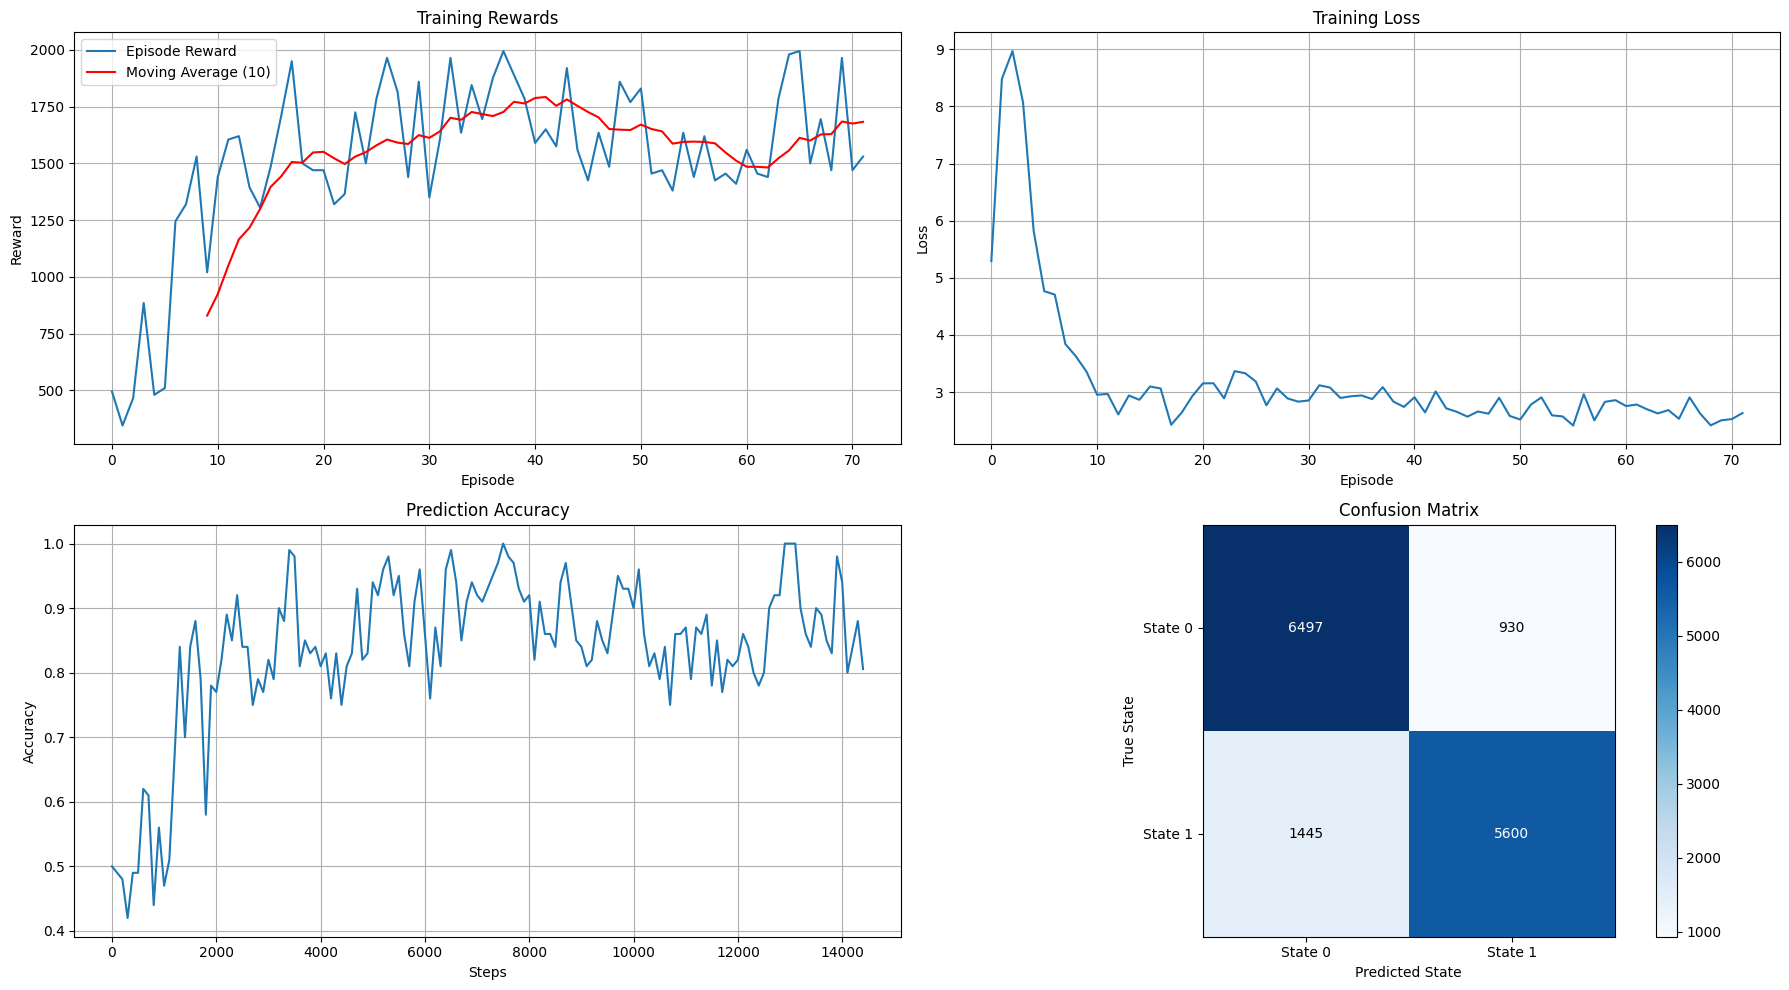


Evaluating on test environment with energy tracking...
Test episode 10/100 completed. Reward: 1965.00, Energy Cost: 10.00
Test episode 20/100 completed. Reward: 1620.00, Energy Cost: 10.00
Test episode 30/100 completed. Reward: 1530.00, Energy Cost: 1.00
Test episode 40/100 completed. Reward: 1545.00, Energy Cost: 10.00
Test episode 50/100 completed. Reward: 1695.00, Energy Cost: 1.00
Test episode 60/100 completed. Reward: 1770.00, Energy Cost: 1.00
Test episode 70/100 completed. Reward: 1695.00, Energy Cost: 10.00
Test episode 80/100 completed. Reward: 1890.00, Energy Cost: 10.00
Test episode 90/100 completed. Reward: 1980.00, Energy Cost: 10.00
Test episode 100/100 completed. Reward: 1455.00, Energy Cost: 10.00

Test Results Summary:
Average reward: 1711.35
Prediction accuracy: 0.9009
Average energy cost: 5.32
Sensing frequency: 50.39%


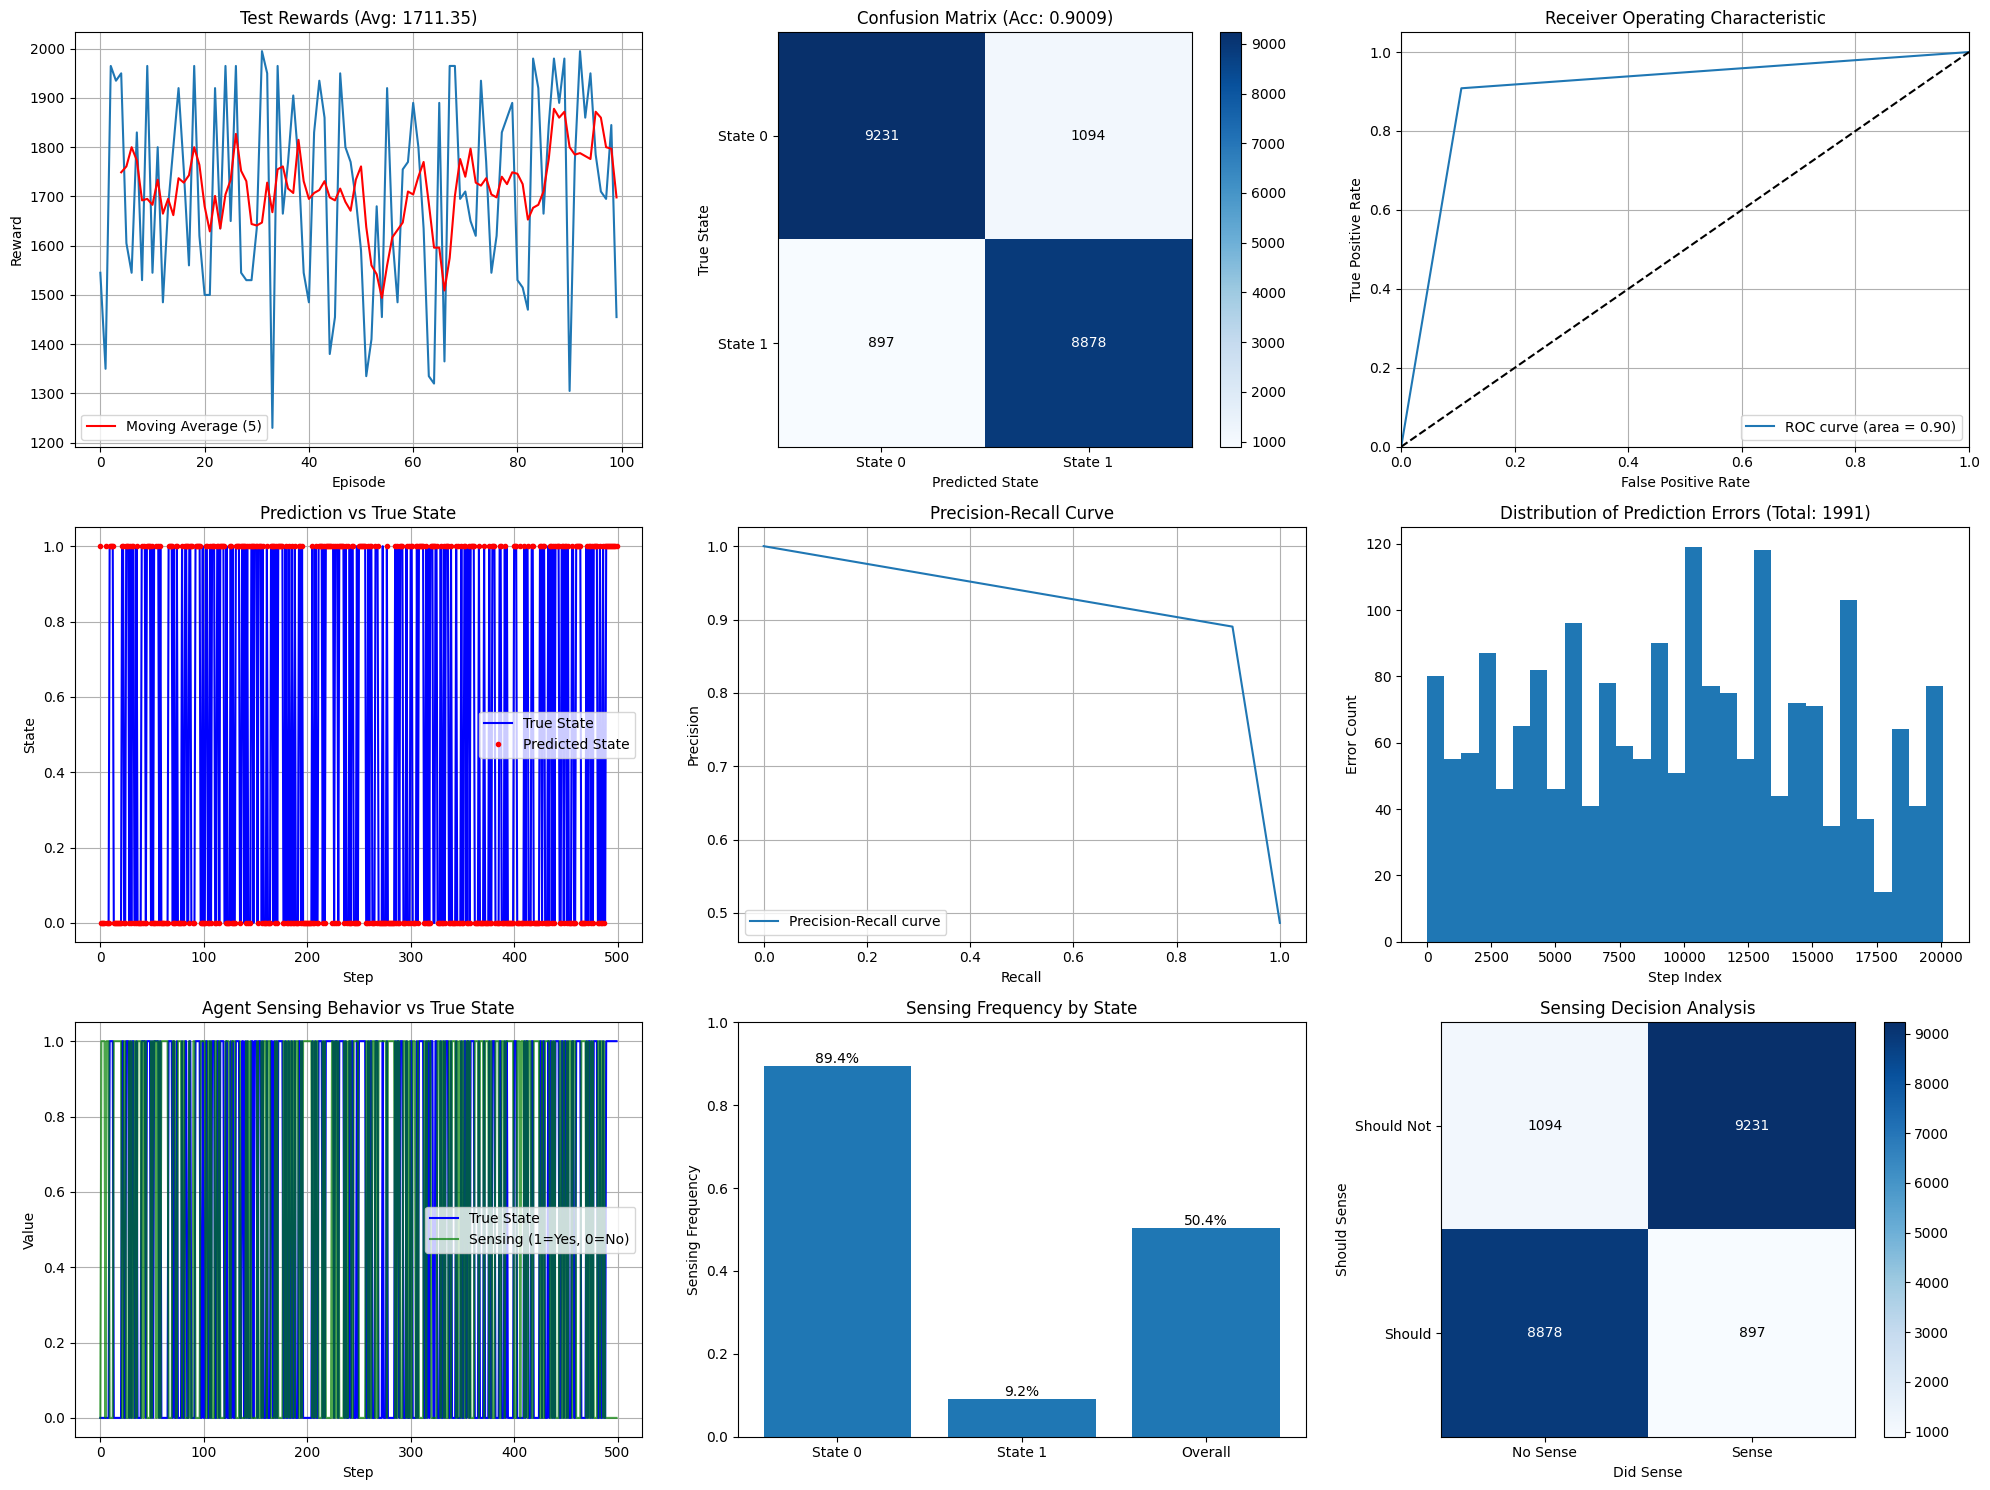

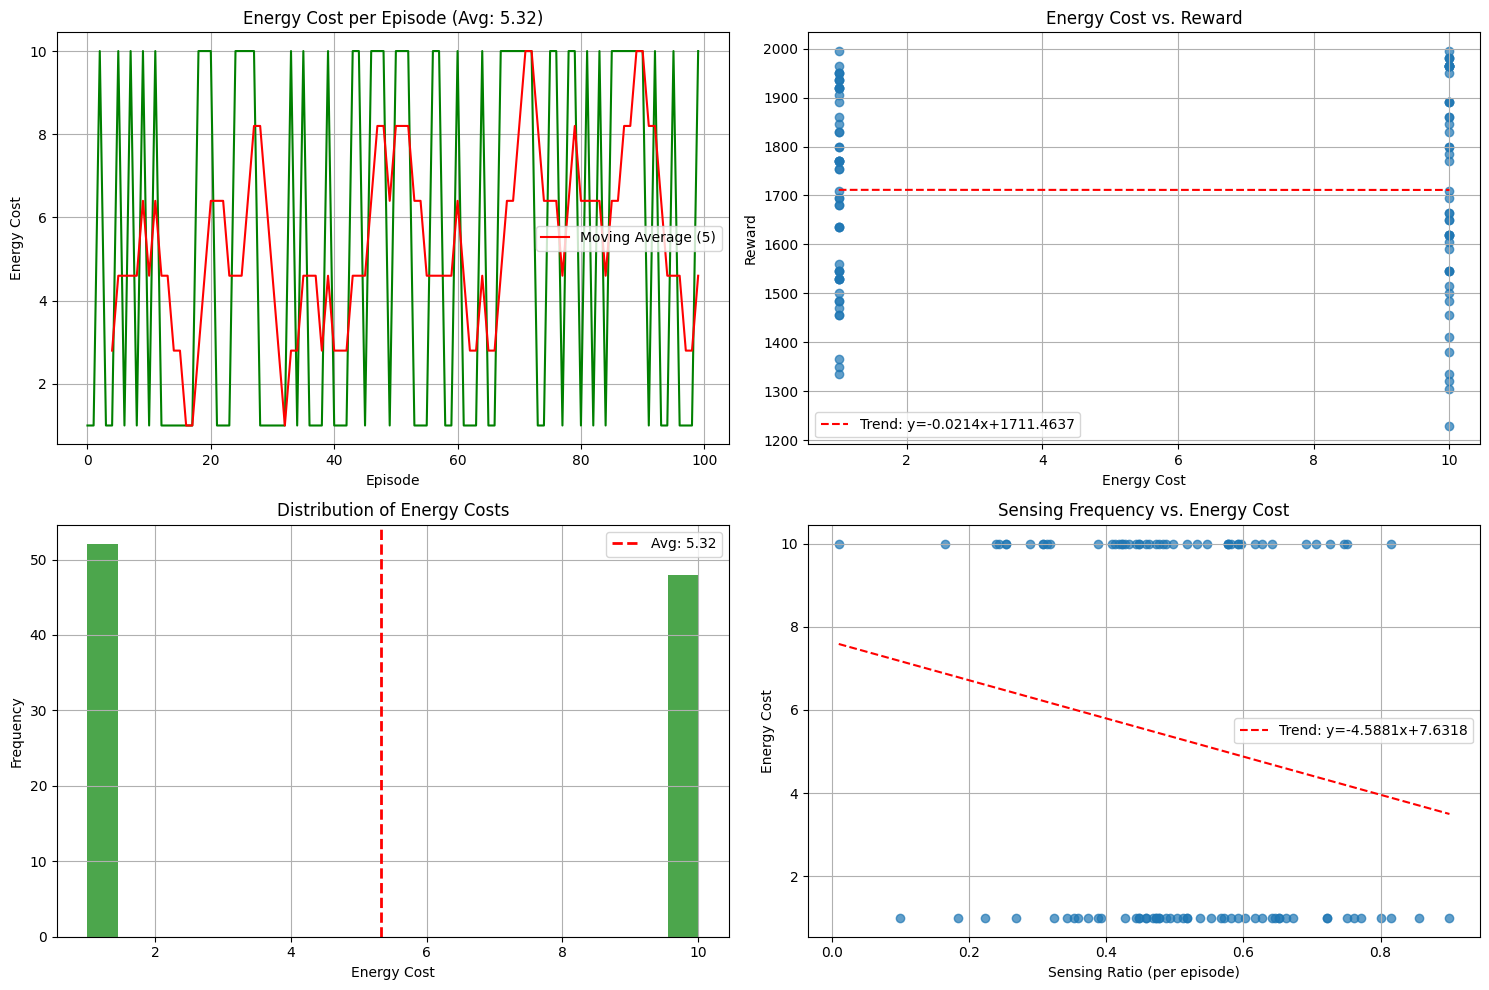


Training vs Test Performance:
Training accuracy: 0.8359
Test accuracy: 0.9009
Accuracy difference: 0.0651
Model generalizes well to the test environment.


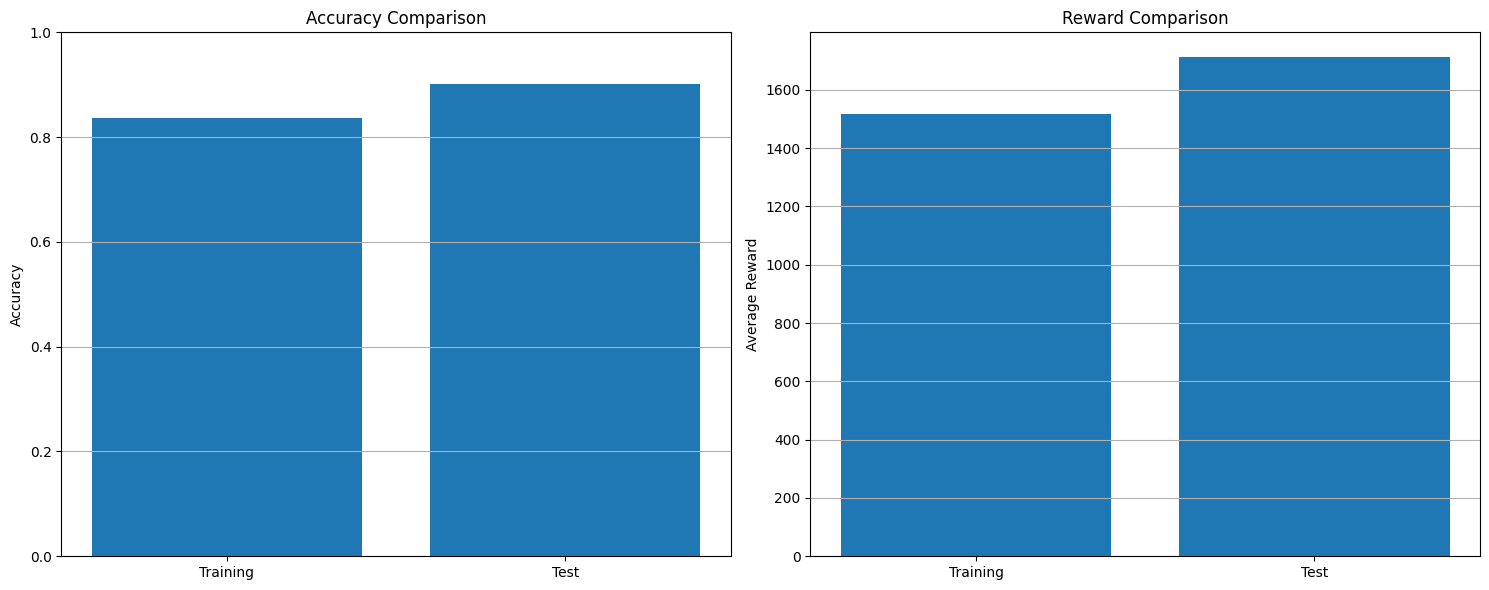

Experiment with separate testing completed!


In [6]:
time_dependence = 1
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

d:\Projects\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Enhanced DQN:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\shyam\AppData\Local\Temp\ipykernel_26028\869039663.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
C:\Users\shyam\AppData\Local\Temp\ipykernel_26028\869039663.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced DQN:   2%|▏         | 10/500 [00:14<12:01,  1.47s/it]

Episode: 10, Reward: 1020.00, Avg Reward (last 10): 829.50, Accuracy: 0.6716, Loss: 3.356388, Epsilon: 1.0000
New best model saved! Avg reward: 829.50


Training Enhanced DQN:   2%|▏         | 11/500 [00:16<11:49,  1.45s/it]

New best model saved! Avg reward: 924.00


Training Enhanced DQN:   2%|▏         | 12/500 [00:17<11:48,  1.45s/it]

New best model saved! Avg reward: 1050.00


Training Enhanced DQN:   3%|▎         | 13/500 [00:19<11:57,  1.47s/it]

New best model saved! Avg reward: 1165.50


Training Enhanced DQN:   3%|▎         | 14/500 [00:20<11:48,  1.46s/it]

New best model saved! Avg reward: 1216.50


Training Enhanced DQN:   3%|▎         | 15/500 [00:22<11:50,  1.46s/it]

New best model saved! Avg reward: 1299.00


Training Enhanced DQN:   3%|▎         | 16/500 [00:23<11:46,  1.46s/it]

New best model saved! Avg reward: 1396.50


Training Enhanced DQN:   3%|▎         | 17/500 [00:25<11:55,  1.48s/it]

New best model saved! Avg reward: 1443.00


Training Enhanced DQN:   4%|▎         | 18/500 [00:26<11:41,  1.46s/it]

New best model saved! Avg reward: 1506.00


Training Enhanced DQN:   4%|▍         | 19/500 [00:27<11:41,  1.46s/it]

Episode: 20, Reward: 1470.00, Avg Reward (last 10): 1548.00, Accuracy: 0.8209, Loss: 2.929565, Epsilon: 1.0000
New best model saved! Avg reward: 1548.00


Training Enhanced DQN:   4%|▍         | 20/500 [00:30<13:16,  1.66s/it]

Evaluation at episode 20: Reward = 949.00


Training Enhanced DQN:   4%|▍         | 21/500 [00:31<12:36,  1.58s/it]

New best model saved! Avg reward: 1551.00


Training Enhanced DQN:   5%|▌         | 26/500 [00:38<11:33,  1.46s/it]

New best model saved! Avg reward: 1579.50


Training Enhanced DQN:   5%|▌         | 27/500 [00:40<11:30,  1.46s/it]

New best model saved! Avg reward: 1605.00


Training Enhanced DQN:   6%|▌         | 30/500 [00:44<11:22,  1.45s/it]

Episode: 30, Reward: 1860.00, Avg Reward (last 10): 1624.50, Accuracy: 0.9502, Loss: 2.832383, Epsilon: 1.0000
New best model saved! Avg reward: 1624.50


Training Enhanced DQN:   6%|▋         | 32/500 [00:47<11:30,  1.48s/it]

New best model saved! Avg reward: 1641.00


Training Enhanced DQN:   7%|▋         | 33/500 [00:49<11:27,  1.47s/it]

New best model saved! Avg reward: 1701.00


Training Enhanced DQN:   7%|▋         | 35/500 [00:51<11:25,  1.47s/it]

New best model saved! Avg reward: 1726.50


Training Enhanced DQN:   8%|▊         | 39/500 [00:58<11:29,  1.49s/it]

New best model saved! Avg reward: 1771.50
Episode: 40, Reward: 1785.00, Avg Reward (last 10): 1764.00, Accuracy: 0.9254, Loss: 2.740677, Epsilon: 1.0000


Training Enhanced DQN:   8%|▊         | 40/500 [01:00<12:49,  1.67s/it]

Evaluation at episode 40: Reward = 1937.00


Training Enhanced DQN:   8%|▊         | 41/500 [01:01<12:20,  1.61s/it]

New best model saved! Avg reward: 1788.00


Training Enhanced DQN:   8%|▊         | 42/500 [01:03<11:56,  1.56s/it]

New best model saved! Avg reward: 1792.50


Training Enhanced DQN:  10%|█         | 50/500 [01:15<11:23,  1.52s/it]

Episode: 50, Reward: 1770.00, Avg Reward (last 10): 1647.00, Accuracy: 0.9204, Loss: 2.582528, Epsilon: 1.0000


Training Enhanced DQN:  12%|█▏        | 59/500 [01:28<11:47,  1.60s/it]

Episode: 60, Reward: 1410.00, Avg Reward (last 10): 1512.00, Accuracy: 0.8010, Loss: 2.858186, Epsilon: 1.0000


Training Enhanced DQN:  12%|█▏        | 60/500 [01:30<12:41,  1.73s/it]

Evaluation at episode 60: Reward = 1526.00


Training Enhanced DQN:  14%|█▍        | 70/500 [01:46<10:47,  1.51s/it]

Episode: 70, Reward: 1965.00, Avg Reward (last 10): 1684.50, Accuracy: 0.9851, Loss: 2.506111, Epsilon: 1.0000


Training Enhanced DQN:  14%|█▍        | 71/500 [01:49<10:59,  1.54s/it]

Early stopping after 72 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8359


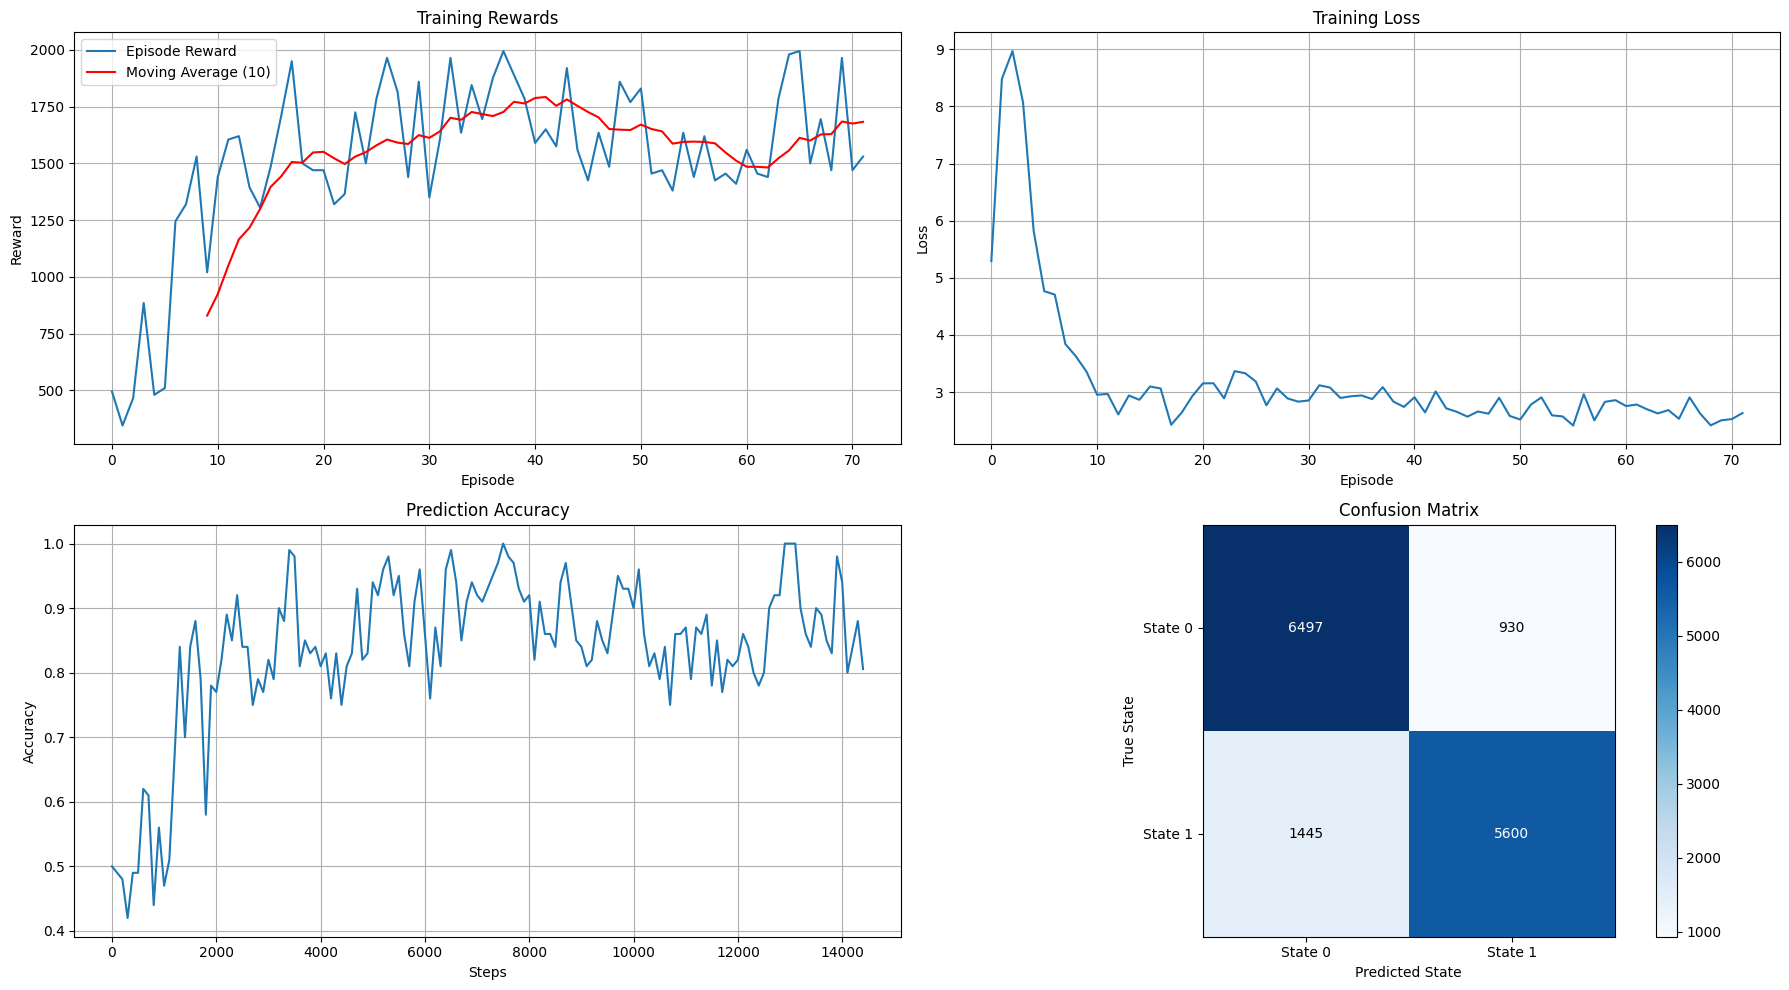


Evaluating on test environment...
Test episode 10/100 completed. Reward: 1710.00
Test episode 20/100 completed. Reward: 1350.00
Test episode 30/100 completed. Reward: 1425.00
Test episode 40/100 completed. Reward: 1635.00
Test episode 50/100 completed. Reward: 1935.00
Test episode 60/100 completed. Reward: 1980.00
Test episode 70/100 completed. Reward: 1965.00
Test episode 80/100 completed. Reward: 1980.00
Test episode 90/100 completed. Reward: 1935.00
Test episode 100/100 completed. Reward: 1980.00

Test Results Summary:
Average reward: 1715.40
Prediction accuracy: 0.9023
Sensing frequency: 51.17%


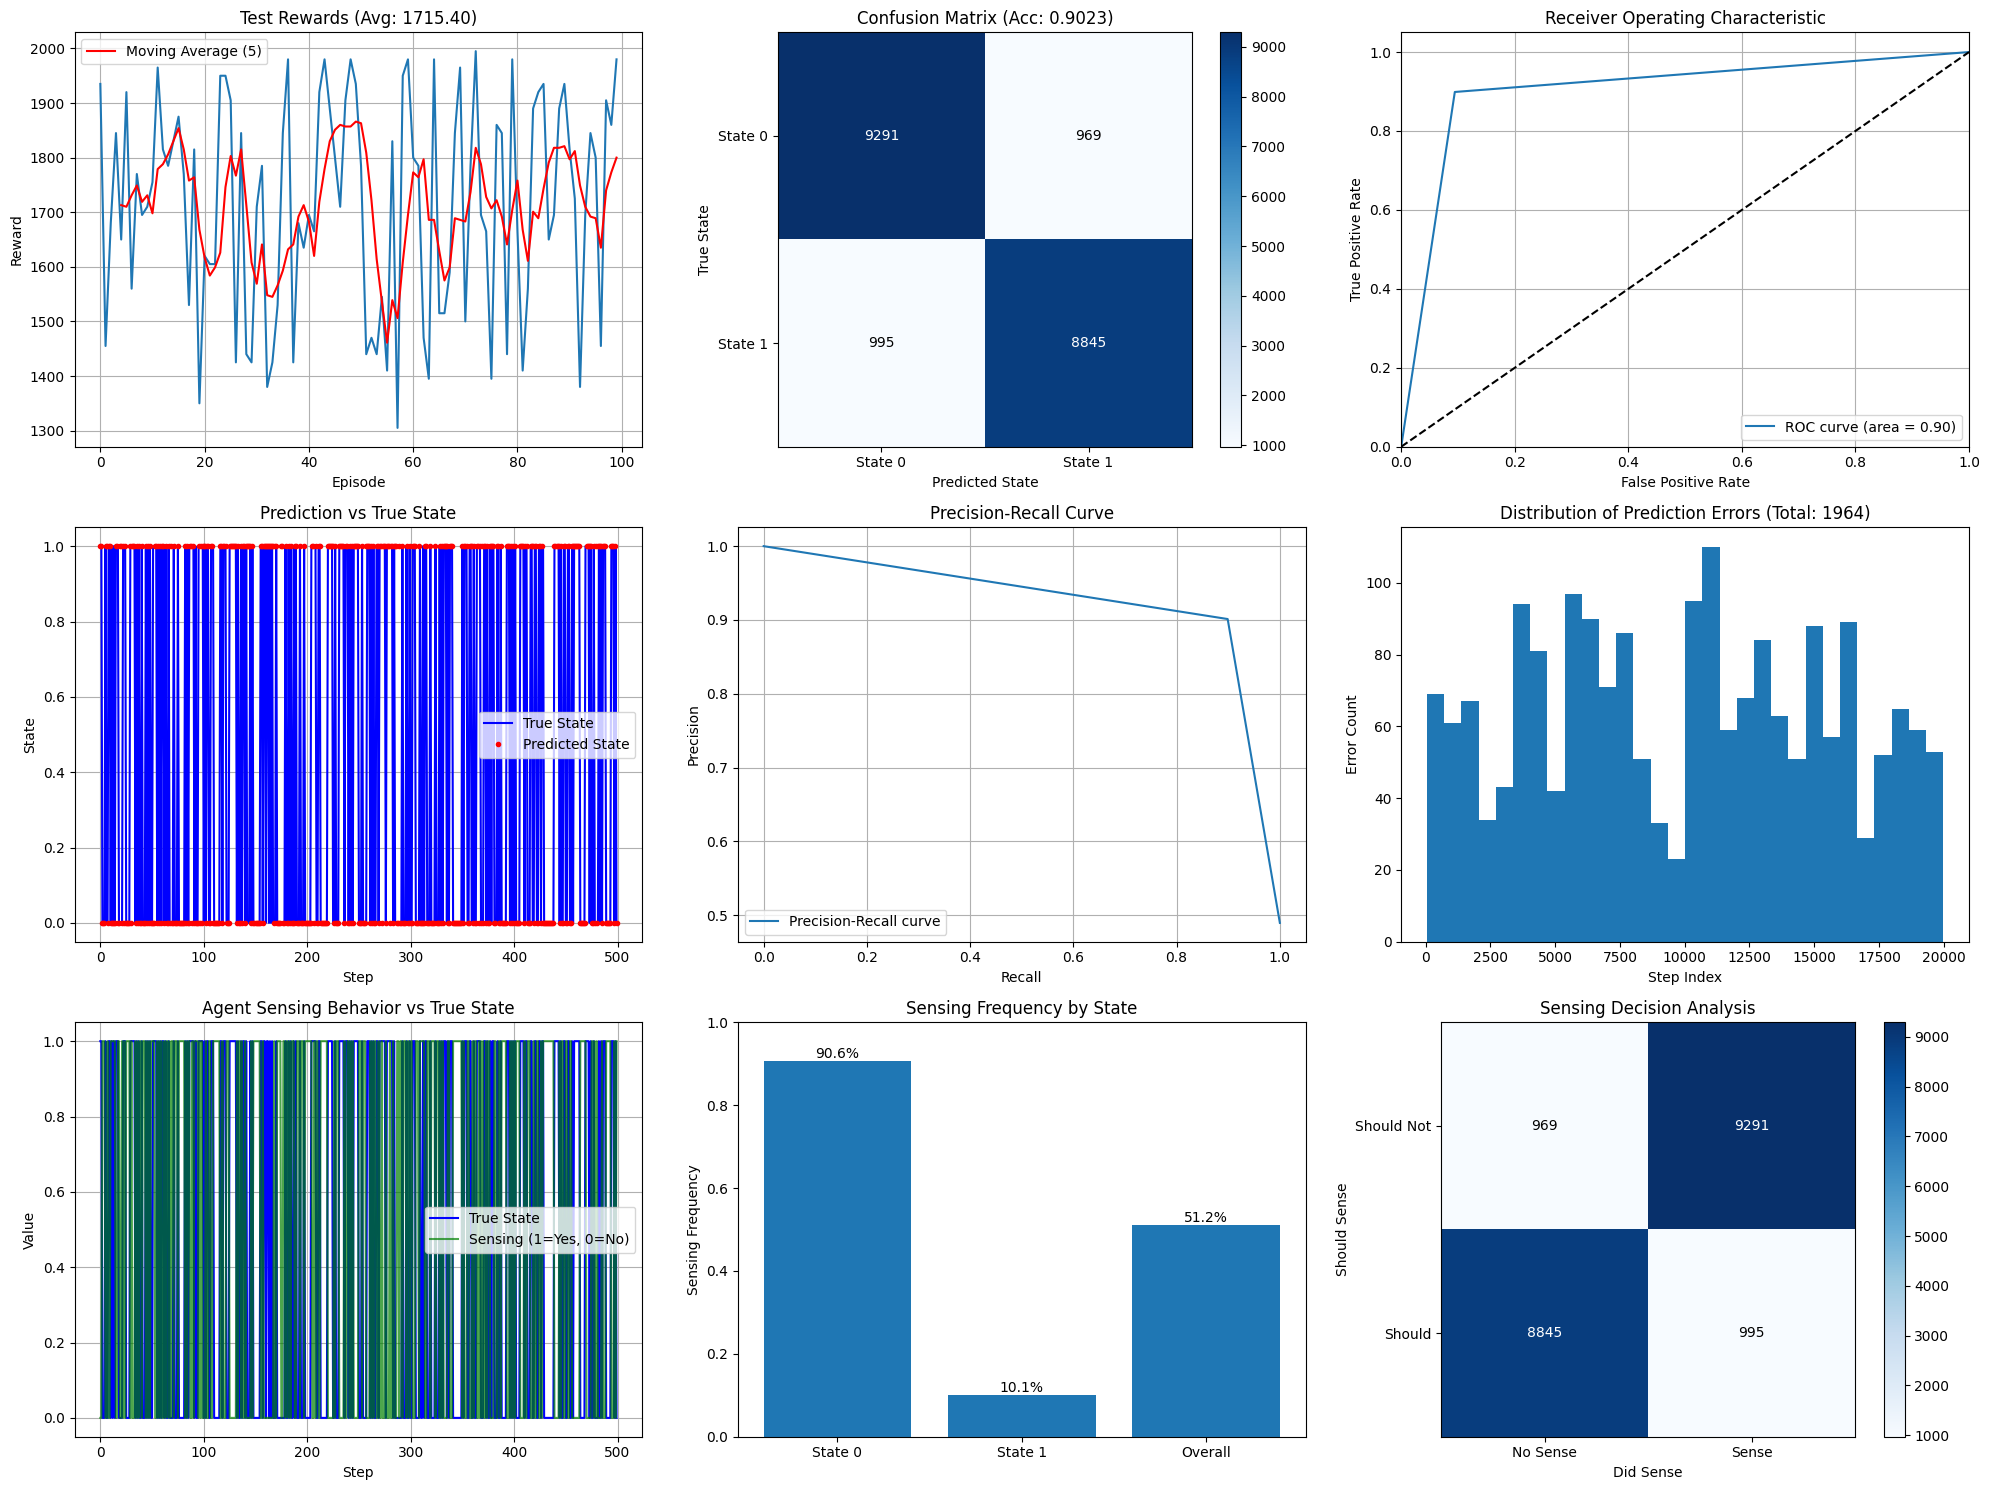


Training vs Test Performance:
Training accuracy: 0.8359
Test accuracy: 0.9023
Accuracy difference: 0.0664
Model generalizes well to the test environment.


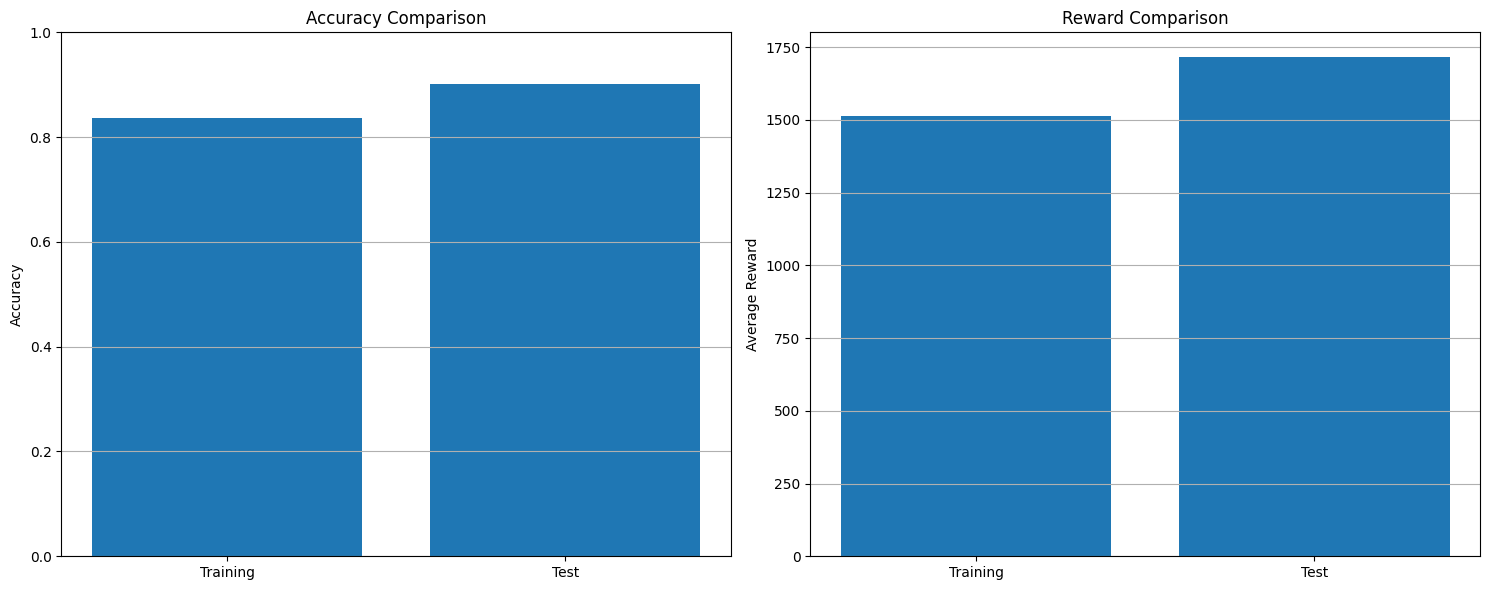

Experiment with separate testing completed!


In [4]:
time_dependence = 2
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

d:\Projects\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Enhanced DQN:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\shyam\AppData\Local\Temp\ipykernel_26028\869039663.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
C:\Users\shyam\AppData\Local\Temp\ipykernel_26028\869039663.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced DQN:   2%|▏         | 10/500 [00:15<12:26,  1.52s/it]

Episode: 10, Reward: 1020.00, Avg Reward (last 10): 829.50, Accuracy: 0.6716, Loss: 3.356388, Epsilon: 1.0000
New best model saved! Avg reward: 829.50


Training Enhanced DQN:   2%|▏         | 11/500 [00:16<12:02,  1.48s/it]

New best model saved! Avg reward: 924.00


Training Enhanced DQN:   2%|▏         | 12/500 [00:17<11:57,  1.47s/it]

New best model saved! Avg reward: 1050.00


Training Enhanced DQN:   3%|▎         | 13/500 [00:19<12:04,  1.49s/it]

New best model saved! Avg reward: 1165.50


Training Enhanced DQN:   3%|▎         | 14/500 [00:20<11:58,  1.48s/it]

New best model saved! Avg reward: 1216.50


Training Enhanced DQN:   3%|▎         | 15/500 [00:22<11:52,  1.47s/it]

New best model saved! Avg reward: 1299.00


Training Enhanced DQN:   3%|▎         | 16/500 [00:23<11:44,  1.45s/it]

New best model saved! Avg reward: 1396.50


Training Enhanced DQN:   3%|▎         | 17/500 [00:25<11:52,  1.48s/it]

New best model saved! Avg reward: 1443.00


Training Enhanced DQN:   4%|▎         | 18/500 [00:26<11:49,  1.47s/it]

New best model saved! Avg reward: 1506.00


Training Enhanced DQN:   4%|▍         | 19/500 [00:28<11:47,  1.47s/it]

Episode: 20, Reward: 1470.00, Avg Reward (last 10): 1548.00, Accuracy: 0.8209, Loss: 2.929565, Epsilon: 1.0000
New best model saved! Avg reward: 1548.00


Training Enhanced DQN:   4%|▍         | 20/500 [00:30<13:25,  1.68s/it]

Evaluation at episode 20: Reward = 949.00


Training Enhanced DQN:   4%|▍         | 21/500 [00:31<12:58,  1.62s/it]

New best model saved! Avg reward: 1551.00


Training Enhanced DQN:   5%|▌         | 26/500 [00:39<11:47,  1.49s/it]

New best model saved! Avg reward: 1579.50


Training Enhanced DQN:   5%|▌         | 27/500 [00:40<11:29,  1.46s/it]

New best model saved! Avg reward: 1605.00


Training Enhanced DQN:   6%|▌         | 30/500 [00:45<11:32,  1.47s/it]

Episode: 30, Reward: 1860.00, Avg Reward (last 10): 1624.50, Accuracy: 0.9502, Loss: 2.832383, Epsilon: 1.0000
New best model saved! Avg reward: 1624.50


Training Enhanced DQN:   6%|▋         | 32/500 [00:48<11:40,  1.50s/it]

New best model saved! Avg reward: 1641.00


Training Enhanced DQN:   7%|▋         | 33/500 [00:49<11:33,  1.48s/it]

New best model saved! Avg reward: 1701.00


Training Enhanced DQN:   7%|▋         | 35/500 [00:52<11:38,  1.50s/it]

New best model saved! Avg reward: 1726.50


Training Enhanced DQN:   8%|▊         | 39/500 [00:58<12:18,  1.60s/it]

New best model saved! Avg reward: 1771.50
Episode: 40, Reward: 1785.00, Avg Reward (last 10): 1764.00, Accuracy: 0.9254, Loss: 2.740677, Epsilon: 1.0000


Training Enhanced DQN:   8%|▊         | 40/500 [01:01<13:40,  1.78s/it]

Evaluation at episode 40: Reward = 1937.00


Training Enhanced DQN:   8%|▊         | 41/500 [01:02<12:59,  1.70s/it]

New best model saved! Avg reward: 1788.00


Training Enhanced DQN:   8%|▊         | 42/500 [01:04<13:07,  1.72s/it]

New best model saved! Avg reward: 1792.50


Training Enhanced DQN:  10%|█         | 50/500 [01:17<11:58,  1.60s/it]

Episode: 50, Reward: 1770.00, Avg Reward (last 10): 1647.00, Accuracy: 0.9204, Loss: 2.582528, Epsilon: 1.0000


Training Enhanced DQN:  12%|█▏        | 59/500 [01:32<11:46,  1.60s/it]

Episode: 60, Reward: 1410.00, Avg Reward (last 10): 1512.00, Accuracy: 0.8010, Loss: 2.858186, Epsilon: 1.0000


Training Enhanced DQN:  12%|█▏        | 60/500 [01:34<13:34,  1.85s/it]

Evaluation at episode 60: Reward = 1526.00


Training Enhanced DQN:  14%|█▍        | 70/500 [01:51<12:09,  1.70s/it]

Episode: 70, Reward: 1965.00, Avg Reward (last 10): 1684.50, Accuracy: 0.9851, Loss: 2.506111, Epsilon: 1.0000


Training Enhanced DQN:  14%|█▍        | 71/500 [01:54<11:31,  1.61s/it]

Early stopping after 72 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8359


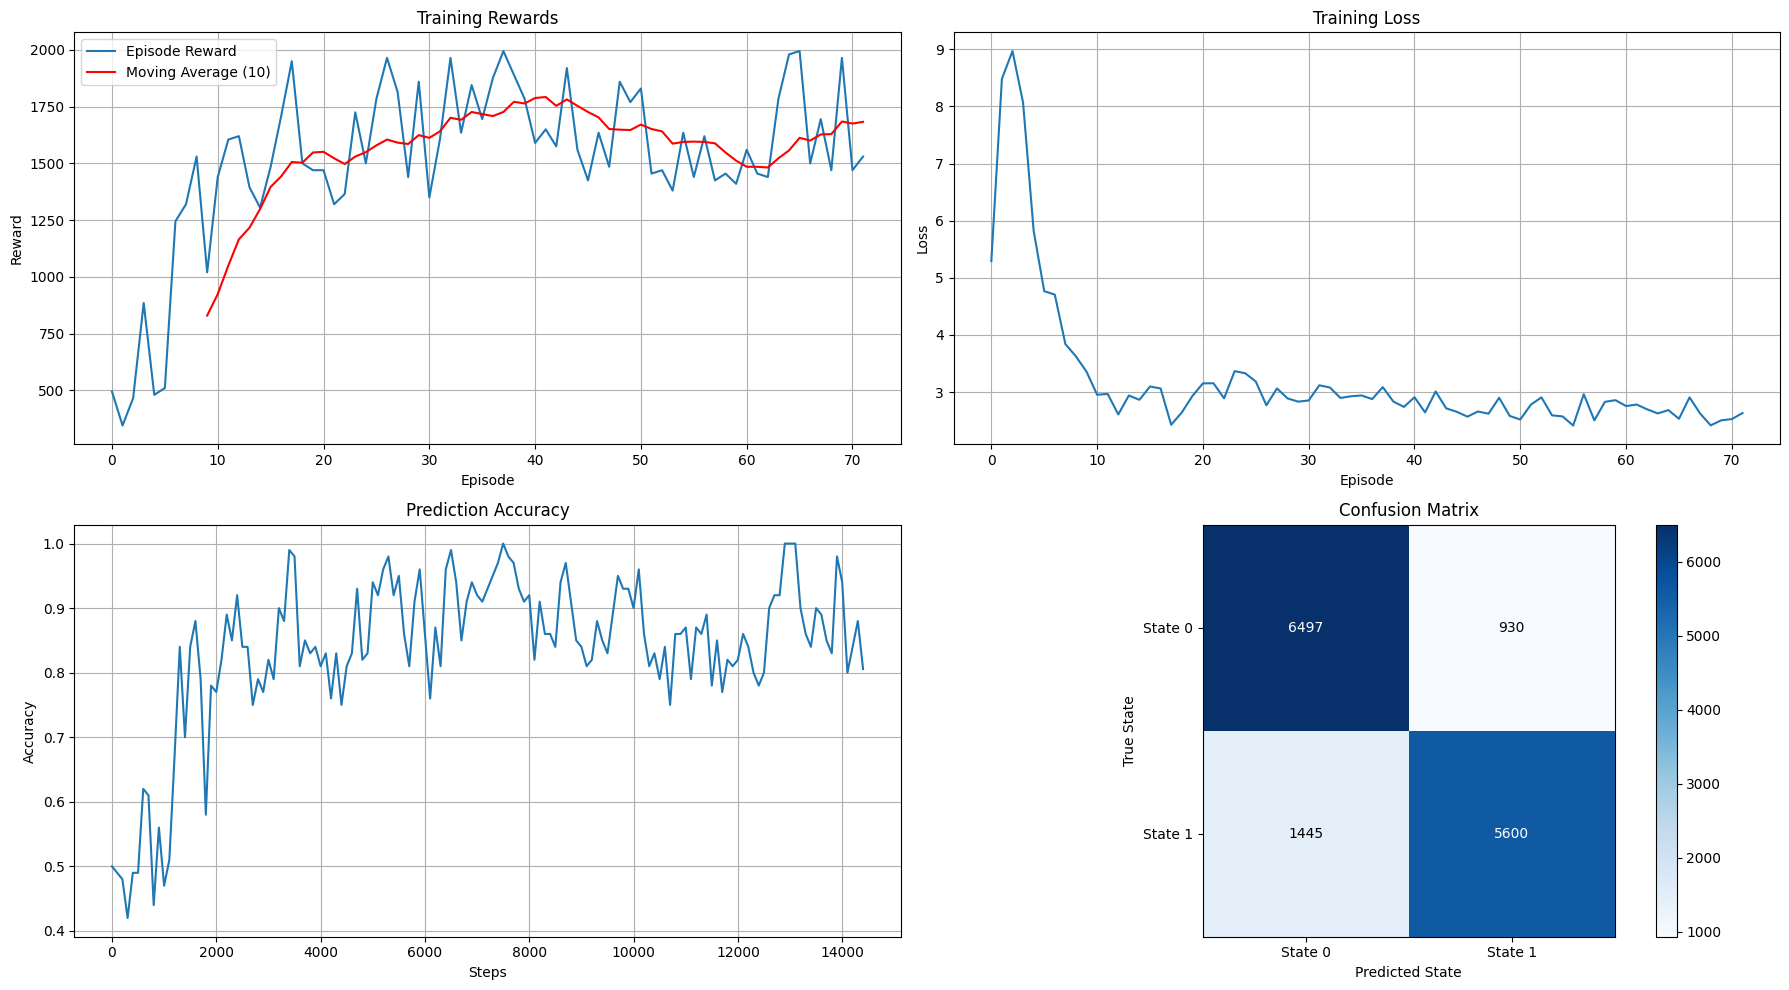


Evaluating on test environment...
Test episode 10/100 completed. Reward: 1485.00
Test episode 20/100 completed. Reward: 1665.00
Test episode 30/100 completed. Reward: 1425.00
Test episode 40/100 completed. Reward: 1935.00
Test episode 50/100 completed. Reward: 1410.00
Test episode 60/100 completed. Reward: 1710.00
Test episode 70/100 completed. Reward: 1425.00
Test episode 80/100 completed. Reward: 1800.00
Test episode 90/100 completed. Reward: 1410.00
Test episode 100/100 completed. Reward: 1770.00

Test Results Summary:
Average reward: 1680.75
Prediction accuracy: 0.8908
Sensing frequency: 50.36%


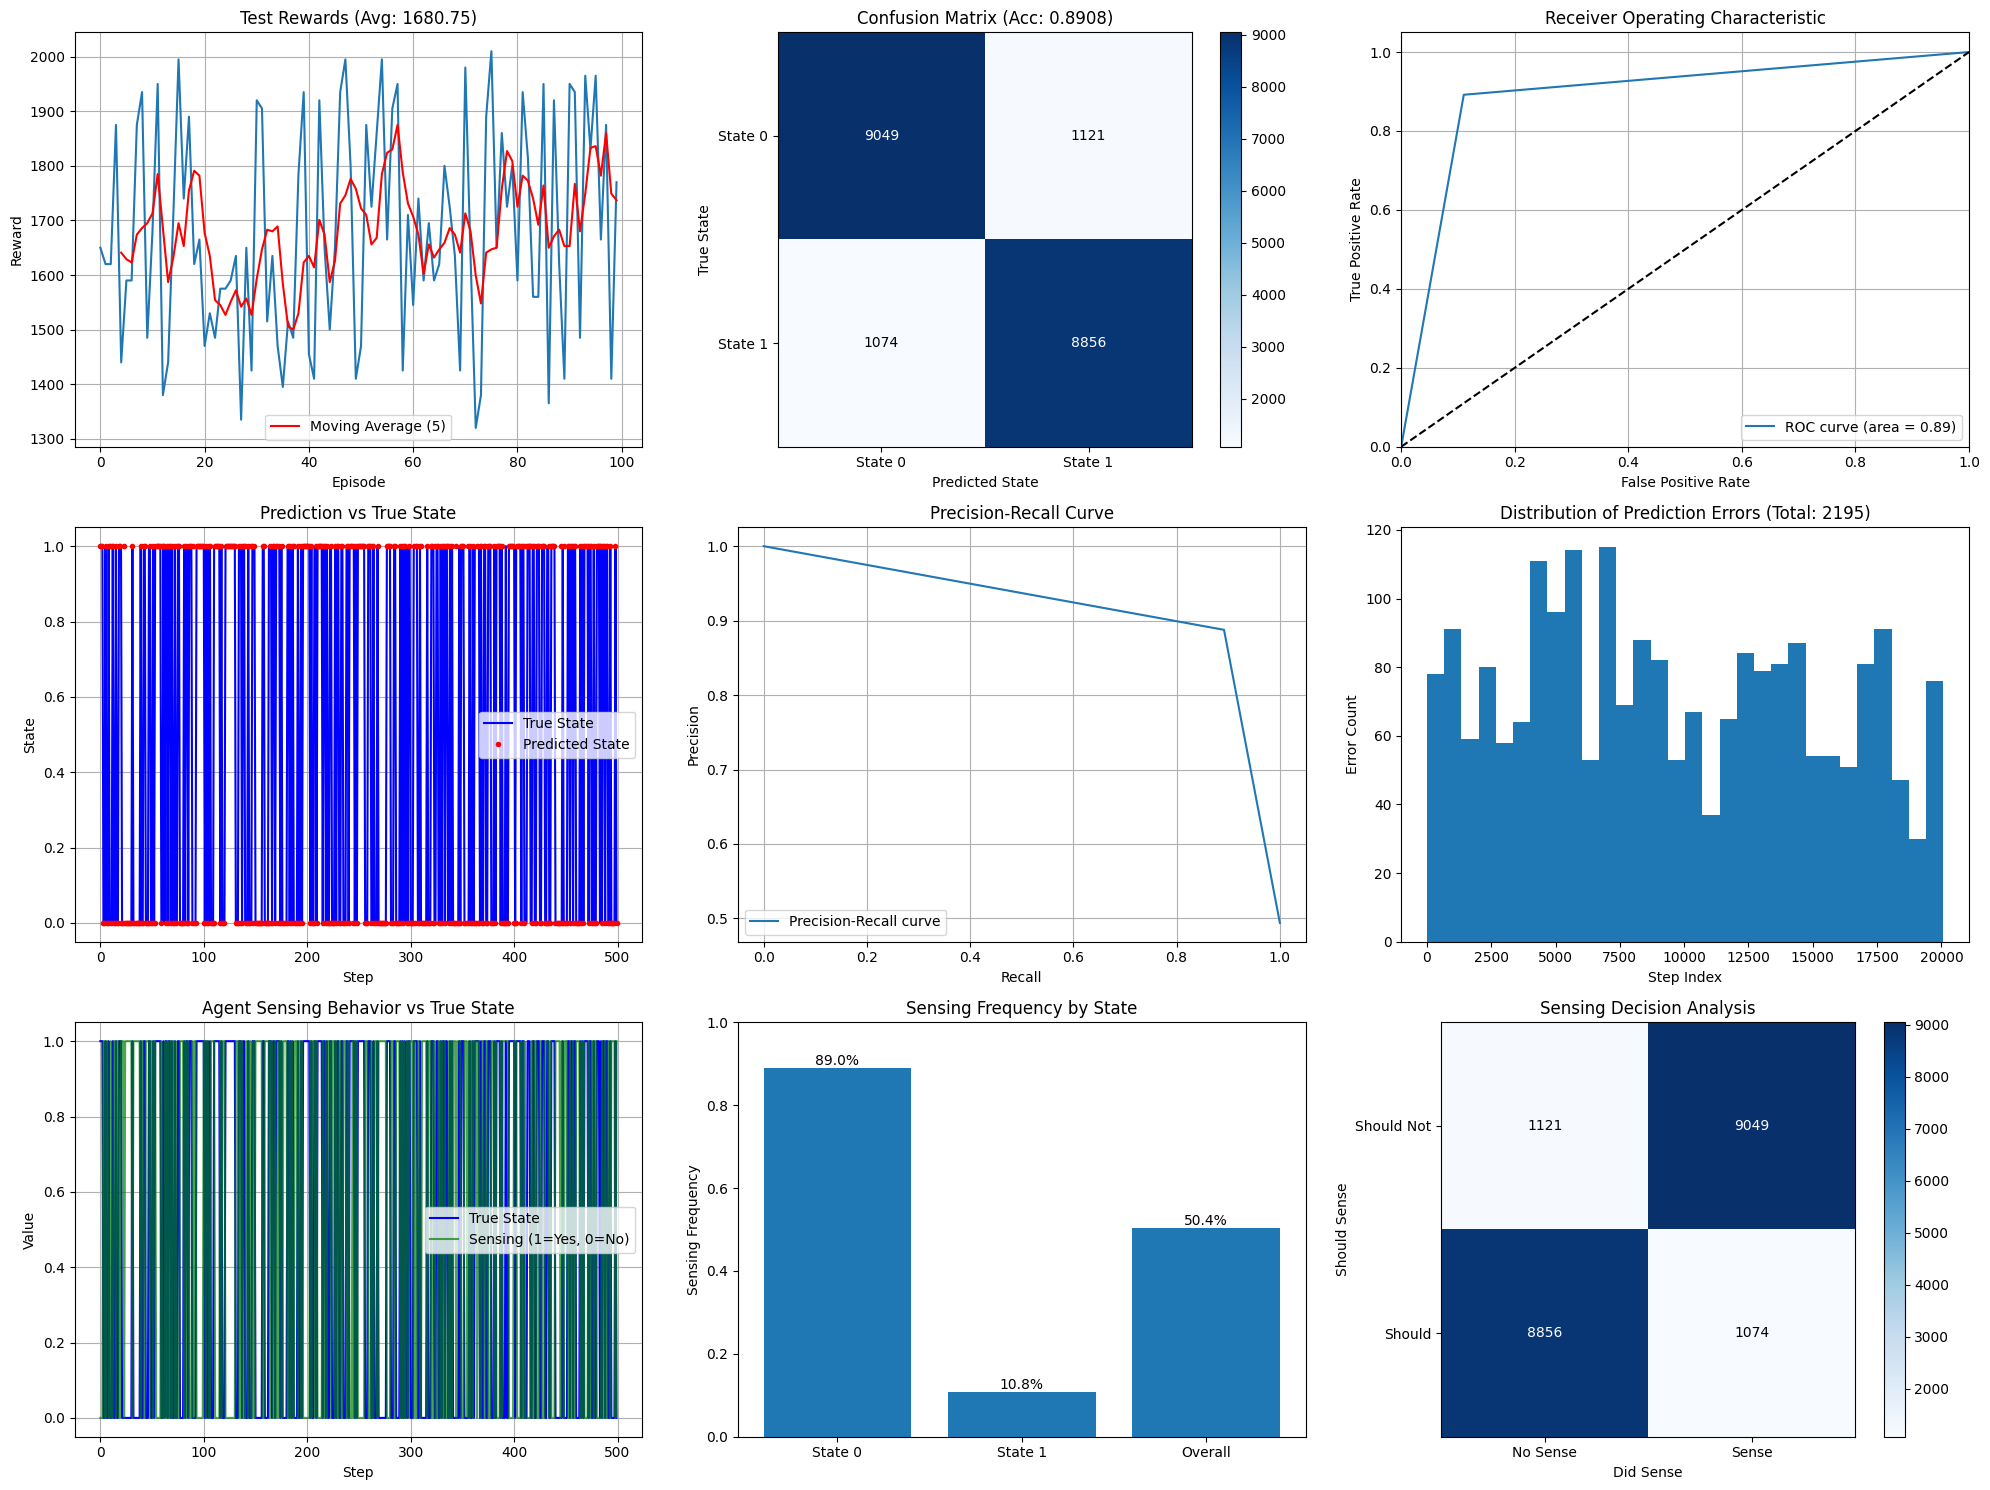


Training vs Test Performance:
Training accuracy: 0.8359
Test accuracy: 0.8908
Accuracy difference: 0.0549
Model generalizes well to the test environment.


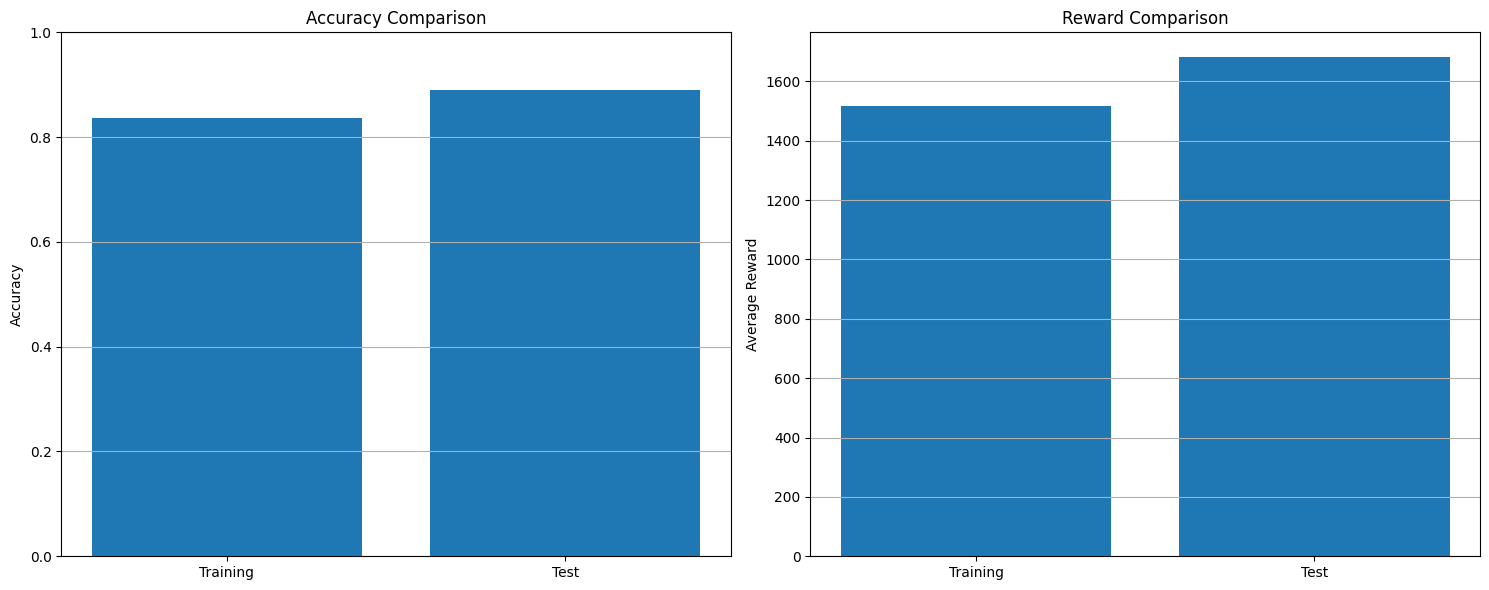

Experiment with separate testing completed!


In [5]:
time_dependence = 3
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)

d:\Projects\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training Enhanced DQN:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\shyam\AppData\Local\Temp\ipykernel_26028\869039663.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = priority
C:\Users\shyam\AppData\Local\Temp\ipykernel_26028\869039663.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[self.position] = priority
Training Enhanced DQN:   2%|▏         | 10/500 [00:18<15:23,  1.89s/it]

Episode: 10, Reward: 1020.00, Avg Reward (last 10): 829.50, Accuracy: 0.6716, Loss: 3.356388, Epsilon: 1.0000
New best model saved! Avg reward: 829.50


Training Enhanced DQN:   2%|▏         | 11/500 [00:21<17:07,  2.10s/it]

New best model saved! Avg reward: 924.00


Training Enhanced DQN:   2%|▏         | 12/500 [00:23<18:02,  2.22s/it]

New best model saved! Avg reward: 1050.00


Training Enhanced DQN:   3%|▎         | 13/500 [00:25<18:05,  2.23s/it]

New best model saved! Avg reward: 1165.50


Training Enhanced DQN:   3%|▎         | 14/500 [00:28<18:04,  2.23s/it]

New best model saved! Avg reward: 1216.50


Training Enhanced DQN:   3%|▎         | 15/500 [00:30<17:24,  2.15s/it]

New best model saved! Avg reward: 1299.00


Training Enhanced DQN:   3%|▎         | 16/500 [00:31<16:00,  1.98s/it]

New best model saved! Avg reward: 1396.50


Training Enhanced DQN:   3%|▎         | 17/500 [00:34<17:17,  2.15s/it]

New best model saved! Avg reward: 1443.00


Training Enhanced DQN:   4%|▎         | 18/500 [00:35<15:40,  1.95s/it]

New best model saved! Avg reward: 1506.00


Training Enhanced DQN:   4%|▍         | 19/500 [00:37<14:53,  1.86s/it]

Episode: 20, Reward: 1470.00, Avg Reward (last 10): 1548.00, Accuracy: 0.8209, Loss: 2.929565, Epsilon: 1.0000
New best model saved! Avg reward: 1548.00


Training Enhanced DQN:   4%|▍         | 20/500 [00:39<15:35,  1.95s/it]

Evaluation at episode 20: Reward = 949.00


Training Enhanced DQN:   4%|▍         | 21/500 [00:41<14:45,  1.85s/it]

New best model saved! Avg reward: 1551.00


Training Enhanced DQN:   5%|▌         | 26/500 [00:48<12:28,  1.58s/it]

New best model saved! Avg reward: 1579.50


Training Enhanced DQN:   5%|▌         | 27/500 [00:50<12:18,  1.56s/it]

New best model saved! Avg reward: 1605.00


Training Enhanced DQN:   6%|▌         | 30/500 [00:55<13:33,  1.73s/it]

Episode: 30, Reward: 1860.00, Avg Reward (last 10): 1624.50, Accuracy: 0.9502, Loss: 2.832383, Epsilon: 1.0000
New best model saved! Avg reward: 1624.50


Training Enhanced DQN:   6%|▋         | 32/500 [00:58<12:51,  1.65s/it]

New best model saved! Avg reward: 1641.00


Training Enhanced DQN:   7%|▋         | 33/500 [01:00<12:48,  1.65s/it]

New best model saved! Avg reward: 1701.00


Training Enhanced DQN:   7%|▋         | 35/500 [01:03<12:36,  1.63s/it]

New best model saved! Avg reward: 1726.50


Training Enhanced DQN:   8%|▊         | 39/500 [01:09<11:45,  1.53s/it]

New best model saved! Avg reward: 1771.50
Episode: 40, Reward: 1785.00, Avg Reward (last 10): 1764.00, Accuracy: 0.9254, Loss: 2.740677, Epsilon: 1.0000


Training Enhanced DQN:   8%|▊         | 40/500 [01:11<12:59,  1.69s/it]

Evaluation at episode 40: Reward = 1937.00


Training Enhanced DQN:   8%|▊         | 41/500 [01:13<12:16,  1.61s/it]

New best model saved! Avg reward: 1788.00


Training Enhanced DQN:   8%|▊         | 42/500 [01:14<12:09,  1.59s/it]

New best model saved! Avg reward: 1792.50


Training Enhanced DQN:  10%|█         | 50/500 [01:26<11:30,  1.53s/it]

Episode: 50, Reward: 1770.00, Avg Reward (last 10): 1647.00, Accuracy: 0.9204, Loss: 2.582528, Epsilon: 1.0000


Training Enhanced DQN:  12%|█▏        | 59/500 [01:40<11:00,  1.50s/it]

Episode: 60, Reward: 1410.00, Avg Reward (last 10): 1512.00, Accuracy: 0.8010, Loss: 2.858186, Epsilon: 1.0000


Training Enhanced DQN:  12%|█▏        | 60/500 [01:42<12:07,  1.65s/it]

Evaluation at episode 60: Reward = 1526.00


Training Enhanced DQN:  14%|█▍        | 70/500 [01:58<12:02,  1.68s/it]

Episode: 70, Reward: 1965.00, Avg Reward (last 10): 1684.50, Accuracy: 0.9851, Loss: 2.506111, Epsilon: 1.0000


Training Enhanced DQN:  14%|█▍        | 71/500 [02:02<12:18,  1.72s/it]

Early stopping after 72 episodes - no improvement for 30 episodes
Training completed. Final accuracy: 0.8359


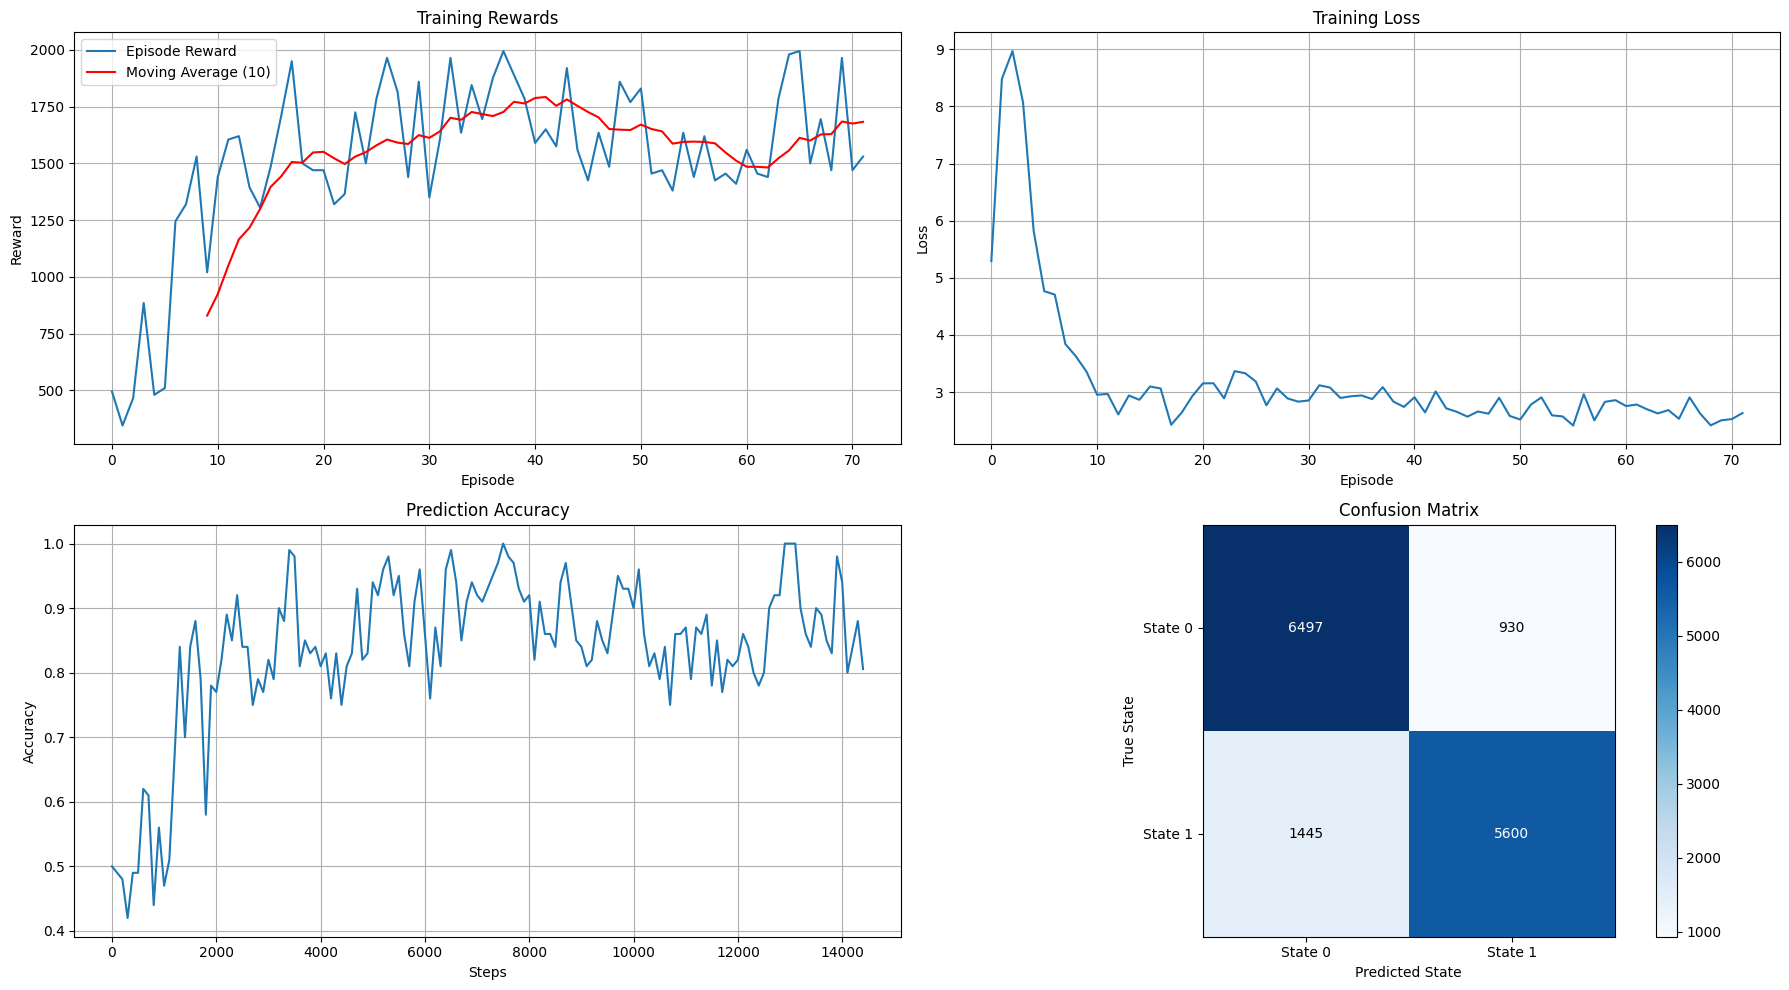


Evaluating on test environment...
Test episode 10/100 completed. Reward: 1665.00
Test episode 20/100 completed. Reward: 1935.00
Test episode 30/100 completed. Reward: 1515.00
Test episode 40/100 completed. Reward: 1575.00
Test episode 50/100 completed. Reward: 1995.00
Test episode 60/100 completed. Reward: 1815.00
Test episode 70/100 completed. Reward: 1425.00
Test episode 80/100 completed. Reward: 1770.00
Test episode 90/100 completed. Reward: 1740.00
Test episode 100/100 completed. Reward: 1995.00

Test Results Summary:
Average reward: 1698.90
Prediction accuracy: 0.8968
Sensing frequency: 48.98%


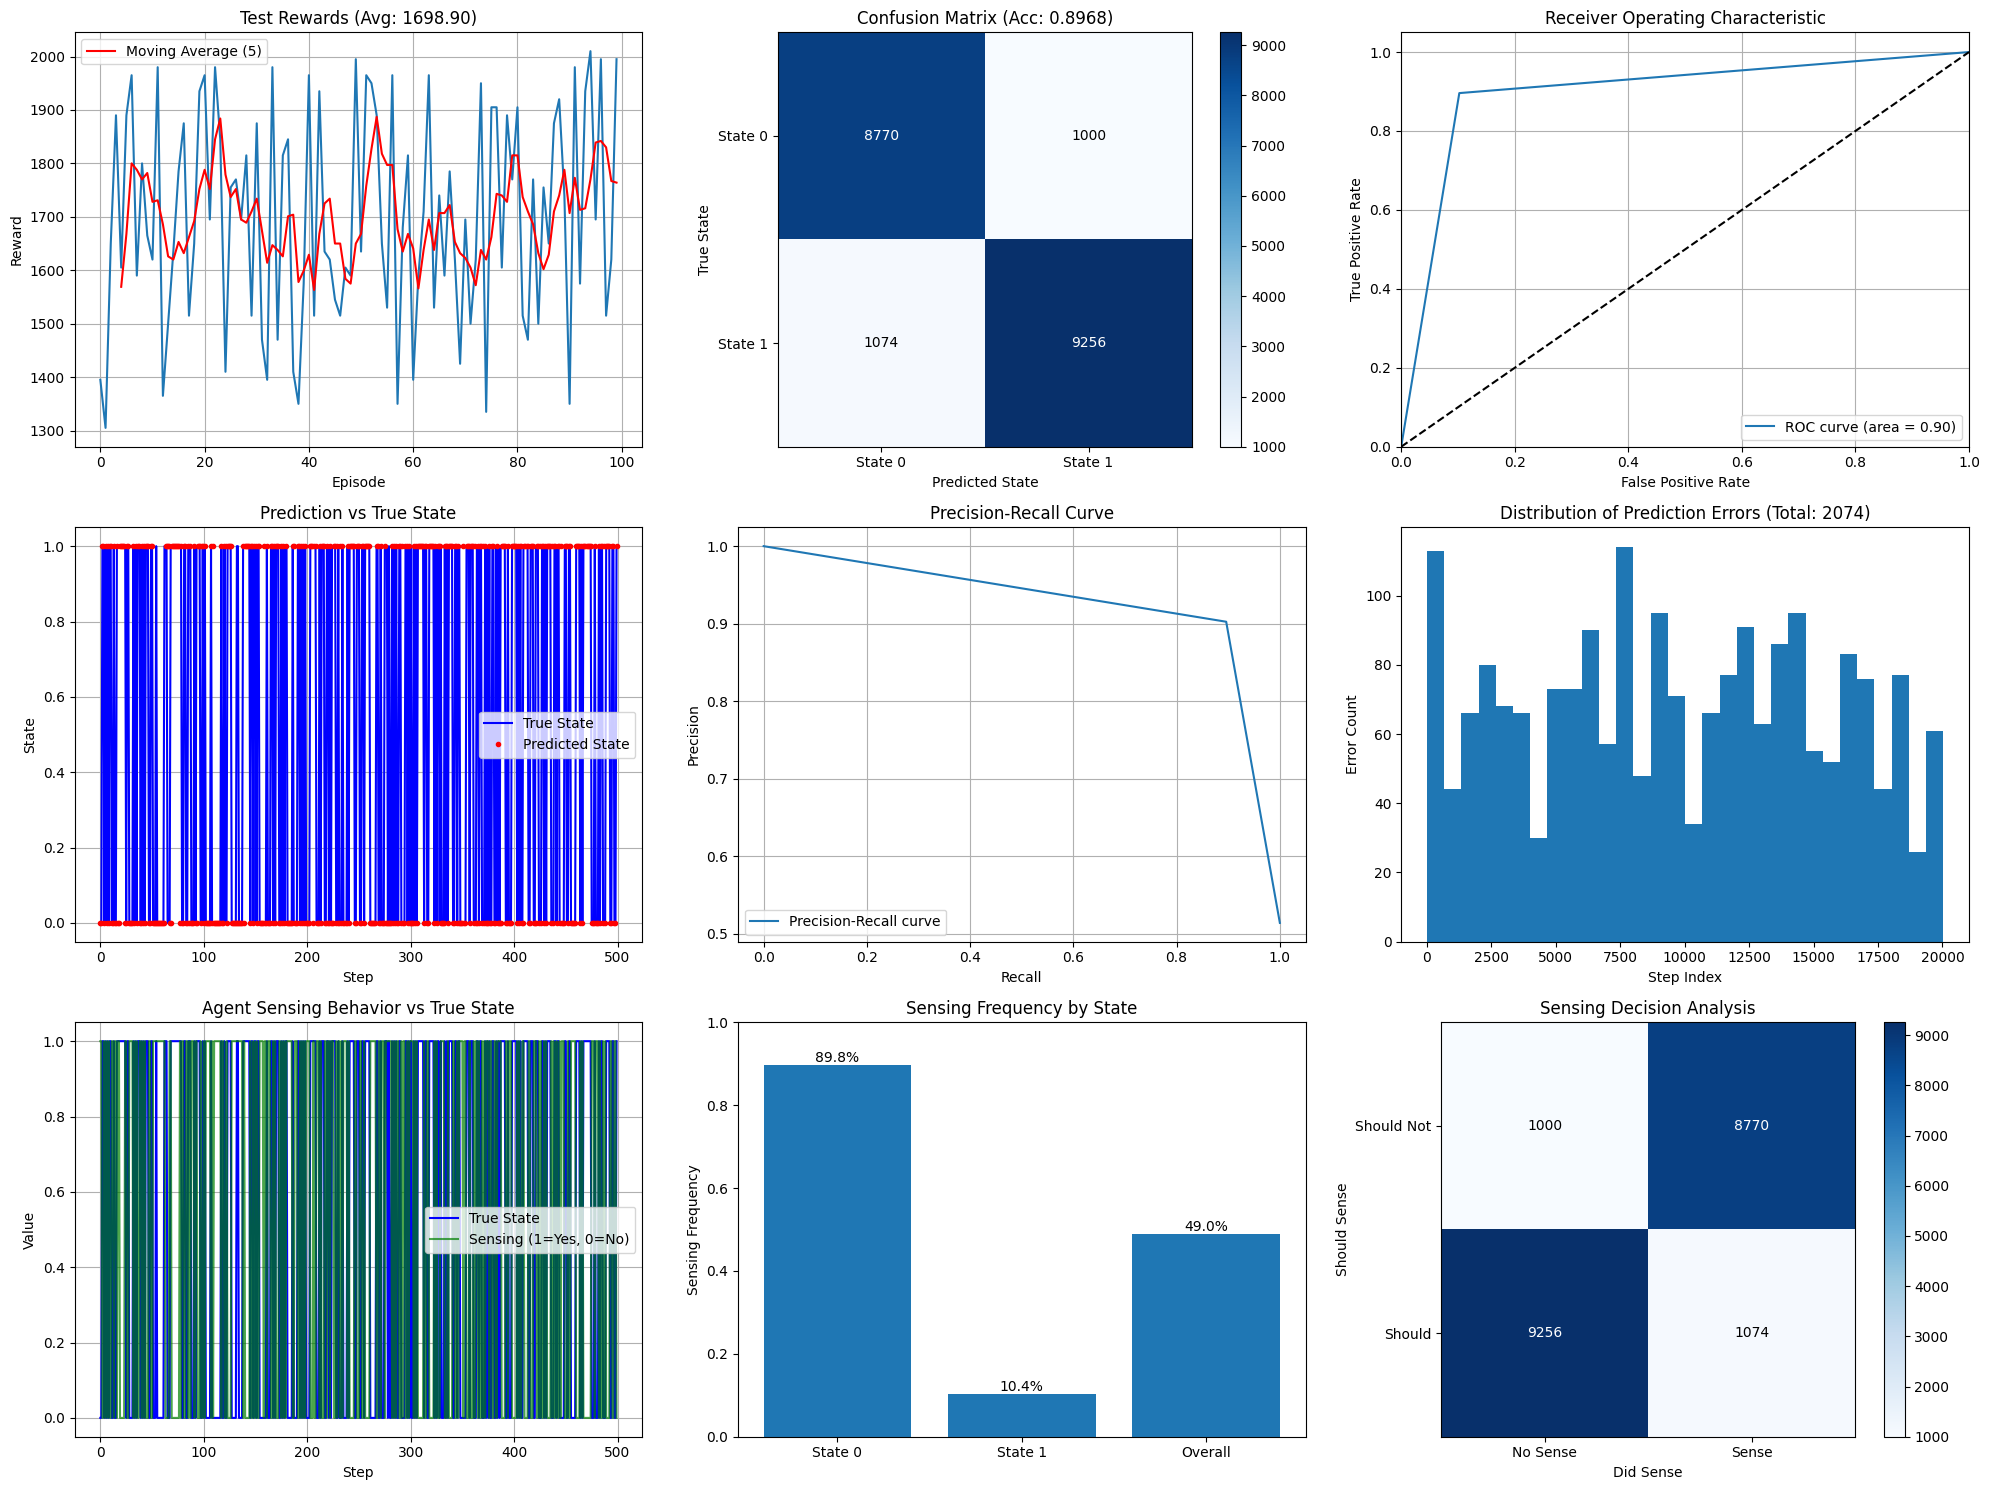


Training vs Test Performance:
Training accuracy: 0.8359
Test accuracy: 0.8968
Accuracy difference: 0.0609
Model generalizes well to the test environment.


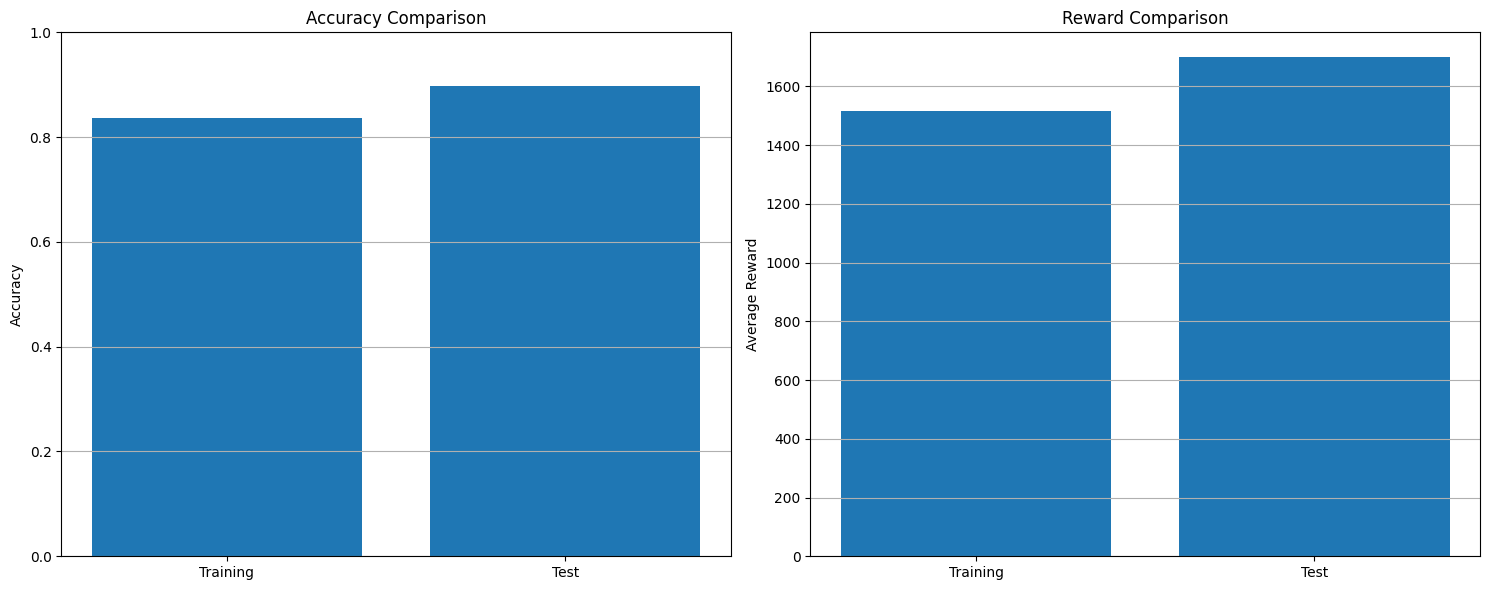

Experiment with separate testing completed!


In [6]:
time_dependence = 4
trained_agent, train_results, test_results = run_experiment_with_testing(
         episodes=500,
         test_episodes=100)